## Configurações de ambiente

In [36]:
# === Standard Library ===
import os
import copy
import pickle
import random

# === Third-party Libraries ===

# Data handling
import numpy as np
import pandas as pd

# Visualization
from great_tables import GT, md, html
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Plotly high-resolution export settings (if needed)
plotly.io.renderers.default = "png"

# Set default font to Helvetica Neue in Plotly
plotly.io.templates["custom"] = plotly.io.templates["plotly_white"]
plotly.io.templates["custom"].layout.font.family = "Helvetica Neue"
plotly.io.templates.default = "custom"

# Matplotlib high-resolution settings
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Helvetica Neue"

# Machine Learning & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)

# Computer vision & augmentation
from PIL import Image
from torchvision import models, transforms

# Optimization
import optuna

# External integrations
import kagglehub

# === Project-specific Imports ===
from dataset import CatsDogsDataset, seed_worker

In [7]:
MODELS_PATH = os.path.join(os.getcwd(), "models")
GRAPHS_PATH = os.path.join(os.getcwd(), "graphs")
OPTUNA_PATH = os.path.join(os.getcwd(), "optuna")
REPORTS_PATH = os.path.join(os.getcwd(), "reports")

In [8]:
torch.set_num_threads(torch.get_num_threads())

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [10]:
# Ensuring deterministic reproducibility
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Importando os dados

In [11]:
path = kagglehub.dataset_download("ashfakyeafi/cat-dog-images-for-classification")
print("Path to dataset files:", path)

Path to dataset files: /Users/vkz/.cache/kagglehub/datasets/ashfakyeafi/cat-dog-images-for-classification/versions/2


In [12]:
cat_dog_path = os.path.join(path, "cat_dog")

In [13]:
# Doing a stratified split to guarantee balanced datasets
df = pd.read_csv(os.path.join(path, "cat_dog.csv"))

train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=123, stratify=df["labels"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=123, stratify=temp_df["labels"]
)

In [14]:
transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)

In [15]:
# Creating datasets and applying transformations to the images
train_dataset = CatsDogsDataset(train_df, cat_dog_path, transform=transform)
val_dataset = CatsDogsDataset(val_df, cat_dog_path, transform=transform)
test_dataset = CatsDogsDataset(test_df, cat_dog_path, transform=transform)

In [16]:
# Creating dataloaders with 4 parallel workers to improve training speed
g = torch.Generator()
g.manual_seed(123)  # deterministic

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    generator=g,
)
val_loader = DataLoader(
    val_dataset, batch_size=32, num_workers=4, worker_init_fn=seed_worker, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=4, worker_init_fn=seed_worker, generator=g
)

## Classes e funções úteis

In [17]:
def get_model_outputs(model, dataloader, device):
    """
    Runs inference on a dataloader and returns predicted labels,
    probabilities, and true labels.

    Returns:
        all_preds (np.ndarray): Binary predictions (0 or 1)
        all_probs (np.ndarray): Predicted probabilities from the model
        all_labels (np.ndarray): Ground-truth labels
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            probs = outputs.squeeze().cpu().numpy()
            preds = (outputs > 0.5).int().squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

In [30]:
def plot_cm_roc(all_labels, all_preds, all_probs, title, filename):
    cm = confusion_matrix(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Confusion Matrix
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Cat", "Dog"],
        yticklabels=["Cat", "Dog"],
        ax=axs[0],
    )
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel("Predicted Label")
    axs[0].set_ylabel("True Label")

    # Plot 2: ROC Curve
    axs[1].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", linewidth=2)
    axs[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axs[1].set_title("Receiver Operating Characteristic (ROC)")
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].legend(loc="lower right")
    axs[1].grid(True)

    plt.suptitle(title, fontsize=16)

    save_path = os.path.join(GRAPHS_PATH, filename)
    plt.savefig(save_path, dpi=300)

    plt.tight_layout()
    plt.show()

In [27]:
def visualize_feature_maps(model, image_tensor, title, filename):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.conv1(image_tensor)
        x = model.pool(F.relu(x))

    feature_maps = x.squeeze(0).cpu()
    num_maps = feature_maps.shape[0]

    plt.figure(figsize=(15, 10))
    for i in range(min(num_maps, 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap="viridis")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)

    save_path = os.path.join(GRAPHS_PATH, filename)
    plt.savefig(save_path, dpi=300)

    plt.show()

In [20]:
def plot_epochs_graphs(res, title, filename):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # Loss subplot
    axs[0].plot(res["train_losses"], label="Train Loss")
    axs[0].plot(res["val_losses"], label="Val Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss over Epochs")
    axs[0].legend()
    axs[0].grid(True, axis="y")

    # Accuracy subplot
    axs[1].plot(res["train_accuracies"], label="Train")
    axs[1].plot(res["val_accuracies"], label="Validation")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy over Epochs")
    axs[1].legend(loc="lower center")
    axs[1].set_ylim(0, 1)
    axs[1].grid(True, axis="y")

    fig.suptitle(title, fontsize=16)

    save_path = os.path.join(GRAPHS_PATH, filename)
    fig.savefig(save_path, dpi=300)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(
    model, train_loader, val_loader, optimizer, criterion, device, epochs=10
):
    """
    Trains a model and evaluates it on the validation set at each epoch.

    Args:
        model (torch.nn.Module): The model to train
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        optimizer (torch.optim.Optimizer): Optimizer for training
        criterion: Loss function (e.g., nn.BCELoss())
        device: Device to run on (e.g., "cuda" or "mps")
        epochs (int): Number of training epochs

    Returns:
        Tuple of 4 lists: (train_losses, train_accuracies, val_losses, val_accuracies)
    """

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).int()
            correct_train += (predicted == labels.int()).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0.5).int()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_acc = correct / total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}%, Val Acc: {val_accuracies[-1]*100:.2f}%"
        )

    model.load_state_dict(best_model_wts)

    return model, {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

In [22]:
def save_outputs(model, model_name, reports, report_name):
    torch.save(model.state_dict(), os.path.join("models", model_name))

    with open(os.path.join("reports", report_name), "wb") as f:
        pickle.dump(
            {
                "train_losses": reports["train_losses"],
                "train_accuracies": reports["train_accuracies"],
                "val_losses": reports["val_losses"],
                "val_accuracies": reports["val_accuracies"],
            },
            f,
        )

In [65]:
def save_classification_report(all_labels, all_preds, filename):
    report = classification_report(
        all_labels, all_preds, target_names=["Cat", "Dog"], digits=4, output_dict=True
    )
    df_report = pd.DataFrame(report).T

    columns_order = ["precision", "recall", "f1-score", "support"]
    df_report = df_report[columns_order]
    df_report = df_report.reset_index().rename(columns={"index": "Class"})

    GT(df_report).tab_header(title="Classification Report").tab_stub(
        rowname_col="Class"
    ).fmt_number(decimals=2).save(os.path.join(GRAPHS_PATH, filename))

## Treinando o modelo usando uma arquitetura base: `SimpleCNN`

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)

        self.fc1 = nn.Linear(128 * 17 * 17, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 74, 74)
        x = self.pool(F.relu(self.conv2(x)))  # -> (64, 36, 36)
        x = self.pool(F.relu(self.conv3(x)))  # -> (128, 17, 17)
        x = x.view(-1, 128 * 17 * 17)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [14]:
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
if "cat_dog_model_v1.pt" not in os.listdir(MODELS_PATH):
    model, simple_reports = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs=30
    )

Epoch 1 - Train Loss: 0.6727, Train Acc: 58.17%, Val Acc: 66.48%
Epoch 2 - Train Loss: 0.5394, Train Acc: 72.25%, Val Acc: 72.75%
Epoch 3 - Train Loss: 0.4506, Train Acc: 78.94%, Val Acc: 78.69%
Epoch 4 - Train Loss: 0.3718, Train Acc: 83.01%, Val Acc: 80.37%
Epoch 5 - Train Loss: 0.2601, Train Acc: 88.91%, Val Acc: 78.88%
Epoch 6 - Train Loss: 0.1287, Train Acc: 95.14%, Val Acc: 79.60%
Epoch 7 - Train Loss: 0.0559, Train Acc: 98.41%, Val Acc: 80.00%
Epoch 8 - Train Loss: 0.0297, Train Acc: 99.22%, Val Acc: 79.36%
Epoch 9 - Train Loss: 0.0295, Train Acc: 99.22%, Val Acc: 78.96%
Epoch 10 - Train Loss: 0.0256, Train Acc: 99.29%, Val Acc: 79.87%
Epoch 11 - Train Loss: 0.0311, Train Acc: 99.18%, Val Acc: 79.97%
Epoch 12 - Train Loss: 0.0164, Train Acc: 99.65%, Val Acc: 80.00%
Epoch 13 - Train Loss: 0.0105, Train Acc: 99.89%, Val Acc: 78.40%
Epoch 14 - Train Loss: 0.0333, Train Acc: 99.09%, Val Acc: 78.83%
Epoch 15 - Train Loss: 0.0275, Train Acc: 99.30%, Val Acc: 78.21%
Epoch 16 - Train Lo

In [ ]:
# Saving the model and results so we do not have to re-train it everytime
save_outputs(model, "cat_dog_model_v1.pt", simple_reports, "cat_dog_model_v1.pkl")

In [24]:
# Loading the saved model
model = SimpleCNN().to(device)
model_path = os.path.join("models", "cat_dog_model_v1.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

# Loading the saved results
results_path = os.path.join("reports", "cat_dog_model_v1.pkl")
with open(results_path, "rb") as f:
    results = pickle.load(f)

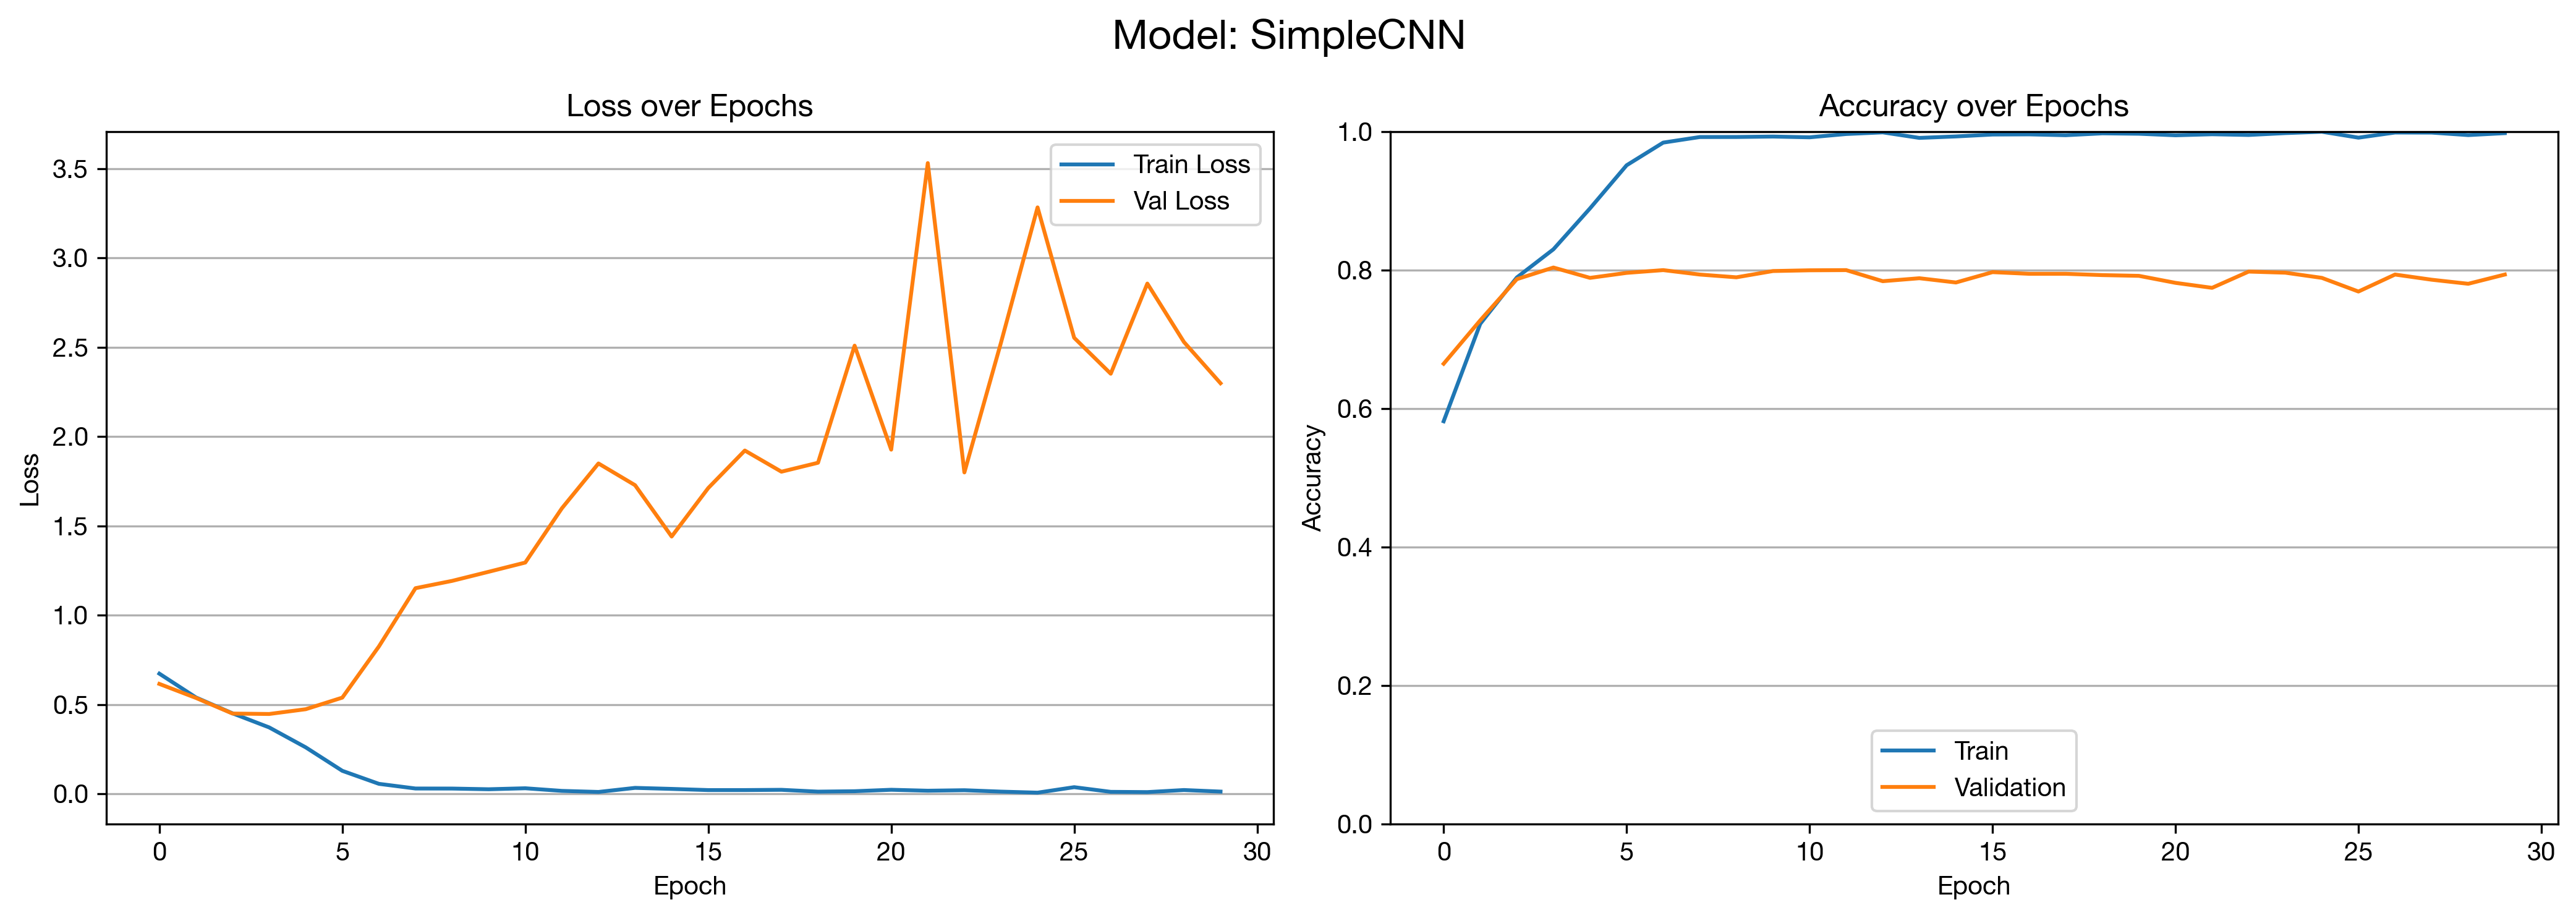

In [ ]:
plot_epochs_graphs(results, title="Model: SimpleCNN", filename="simplecnn_epochs.png")

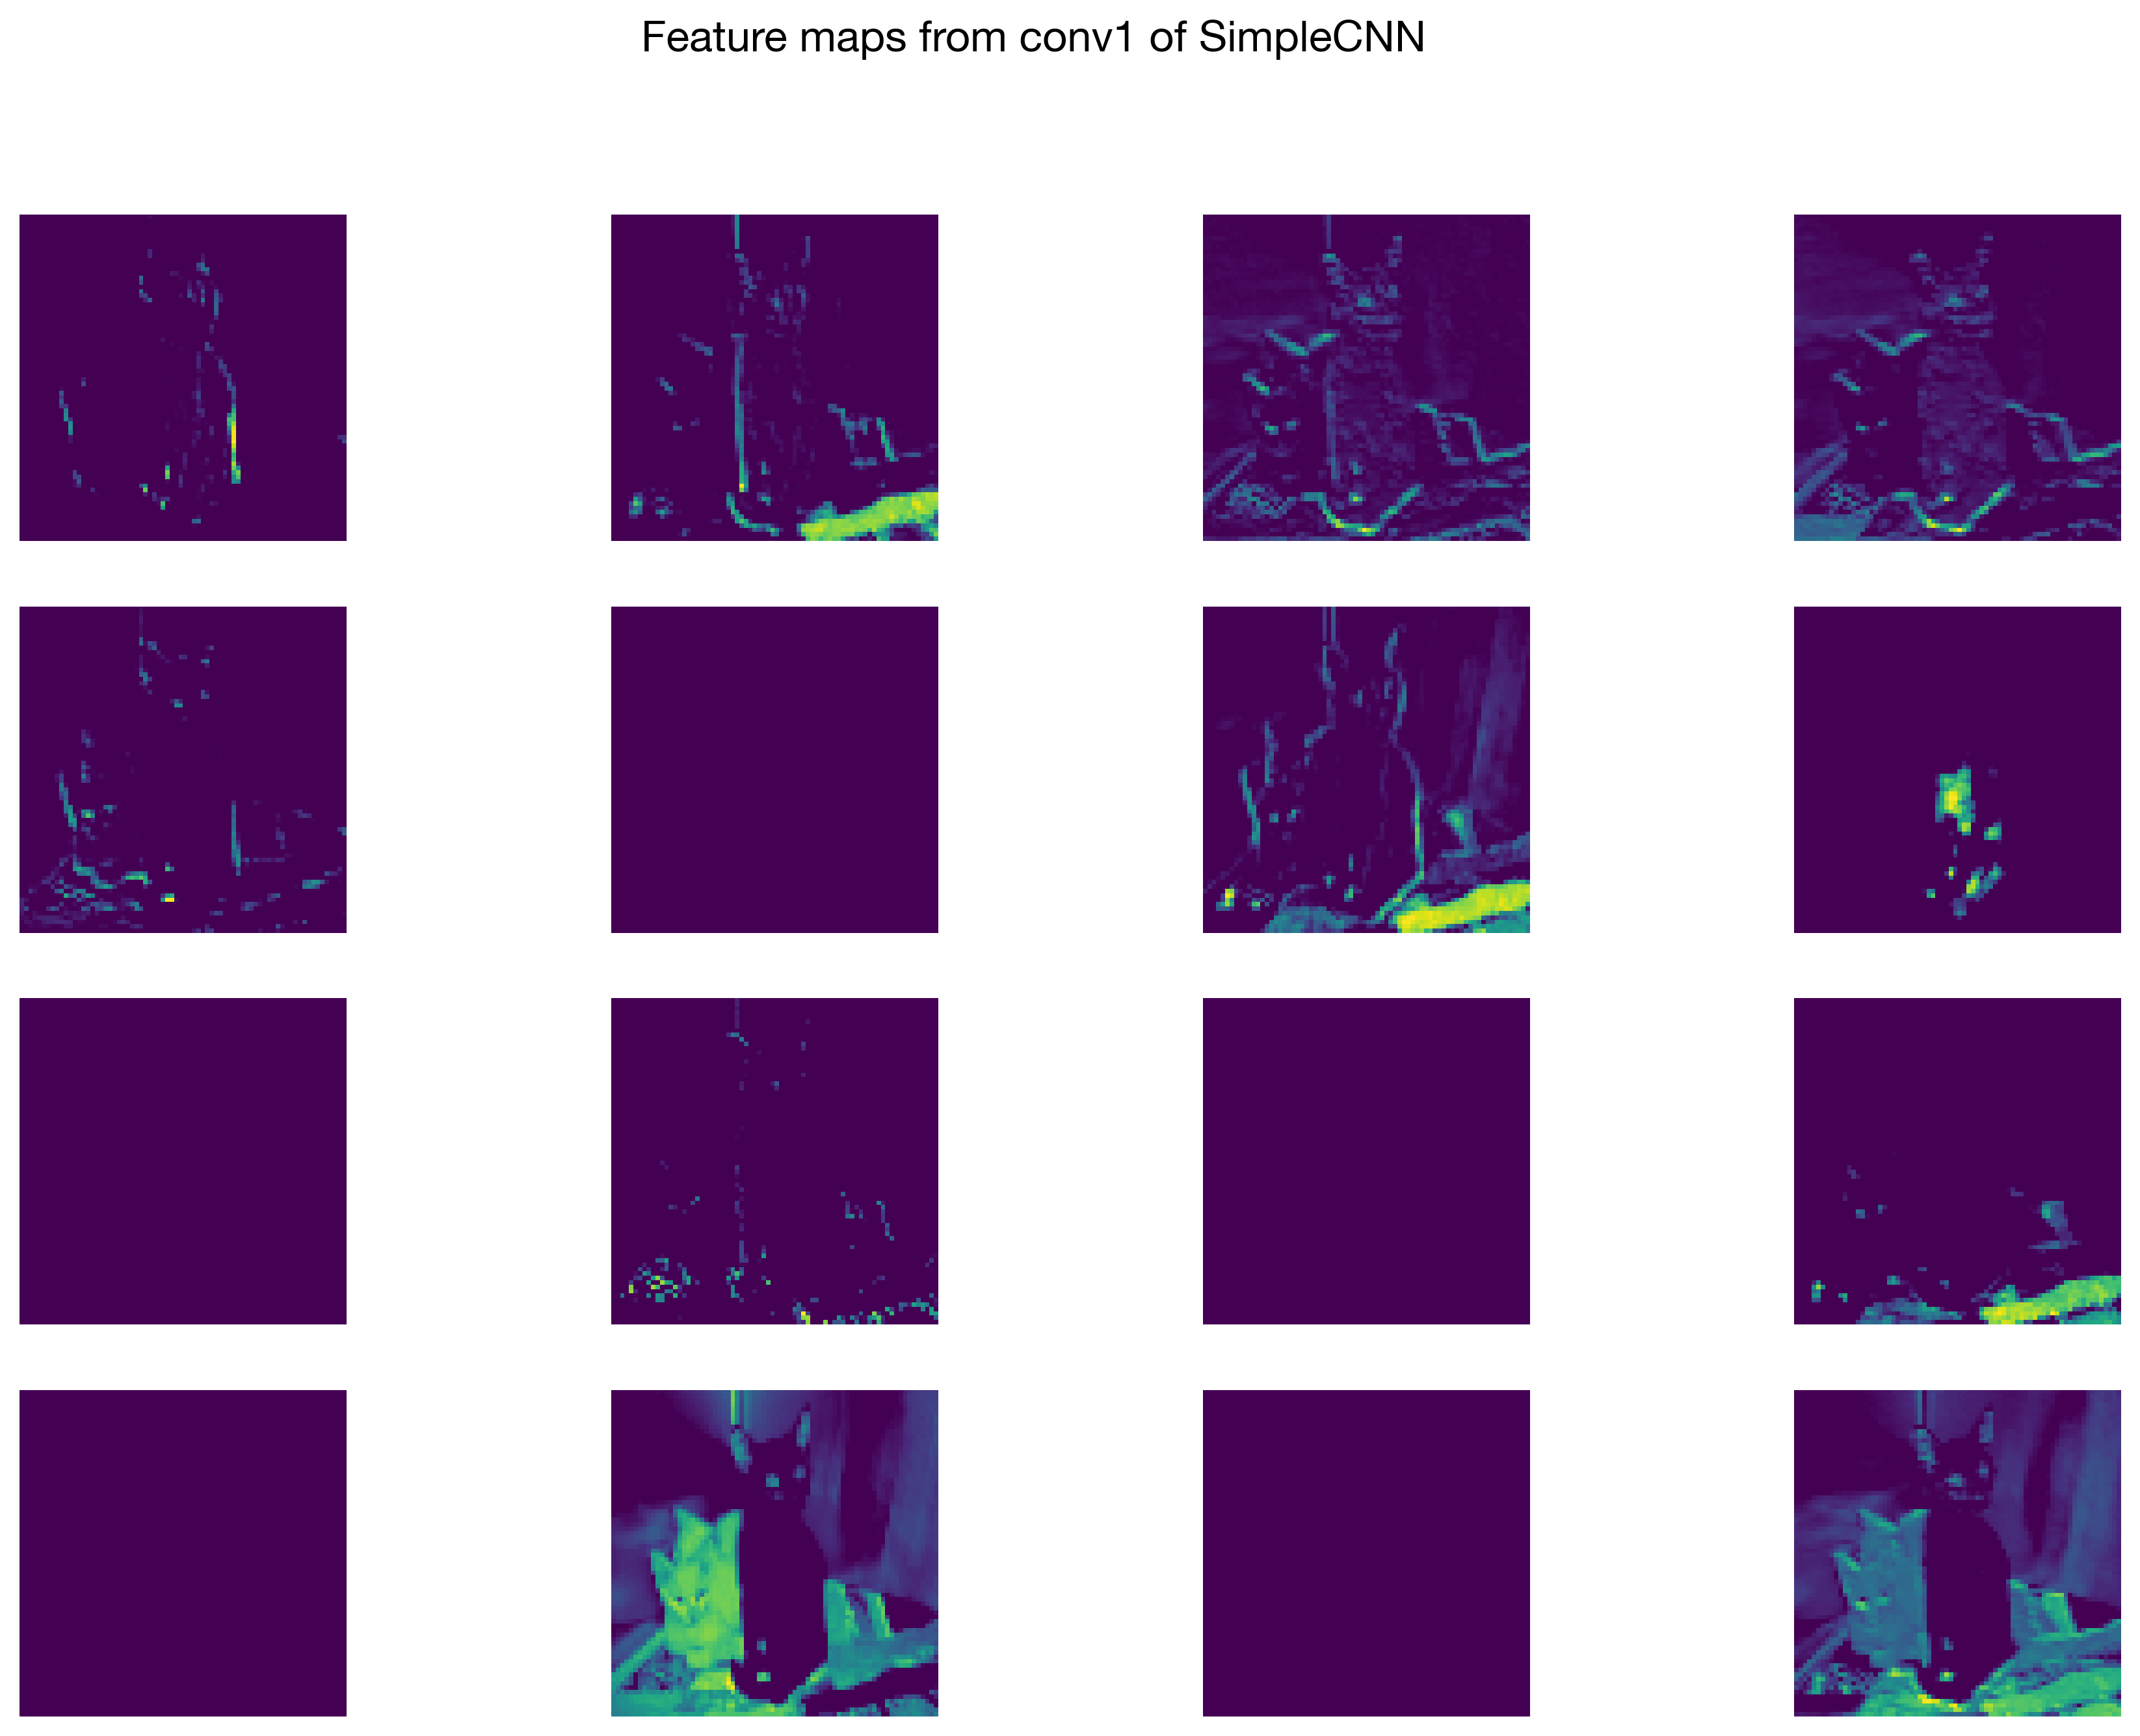

In [28]:
sample_image, _ = next(iter(test_loader))
visualize_feature_maps(
    model,
    sample_image[0],
    title="Feature maps from conv1 of SimpleCNN",
    filename="fm_simplecnn.png",
)

In [29]:
all_preds, all_probs, all_labels = get_model_outputs(model, test_loader, device)

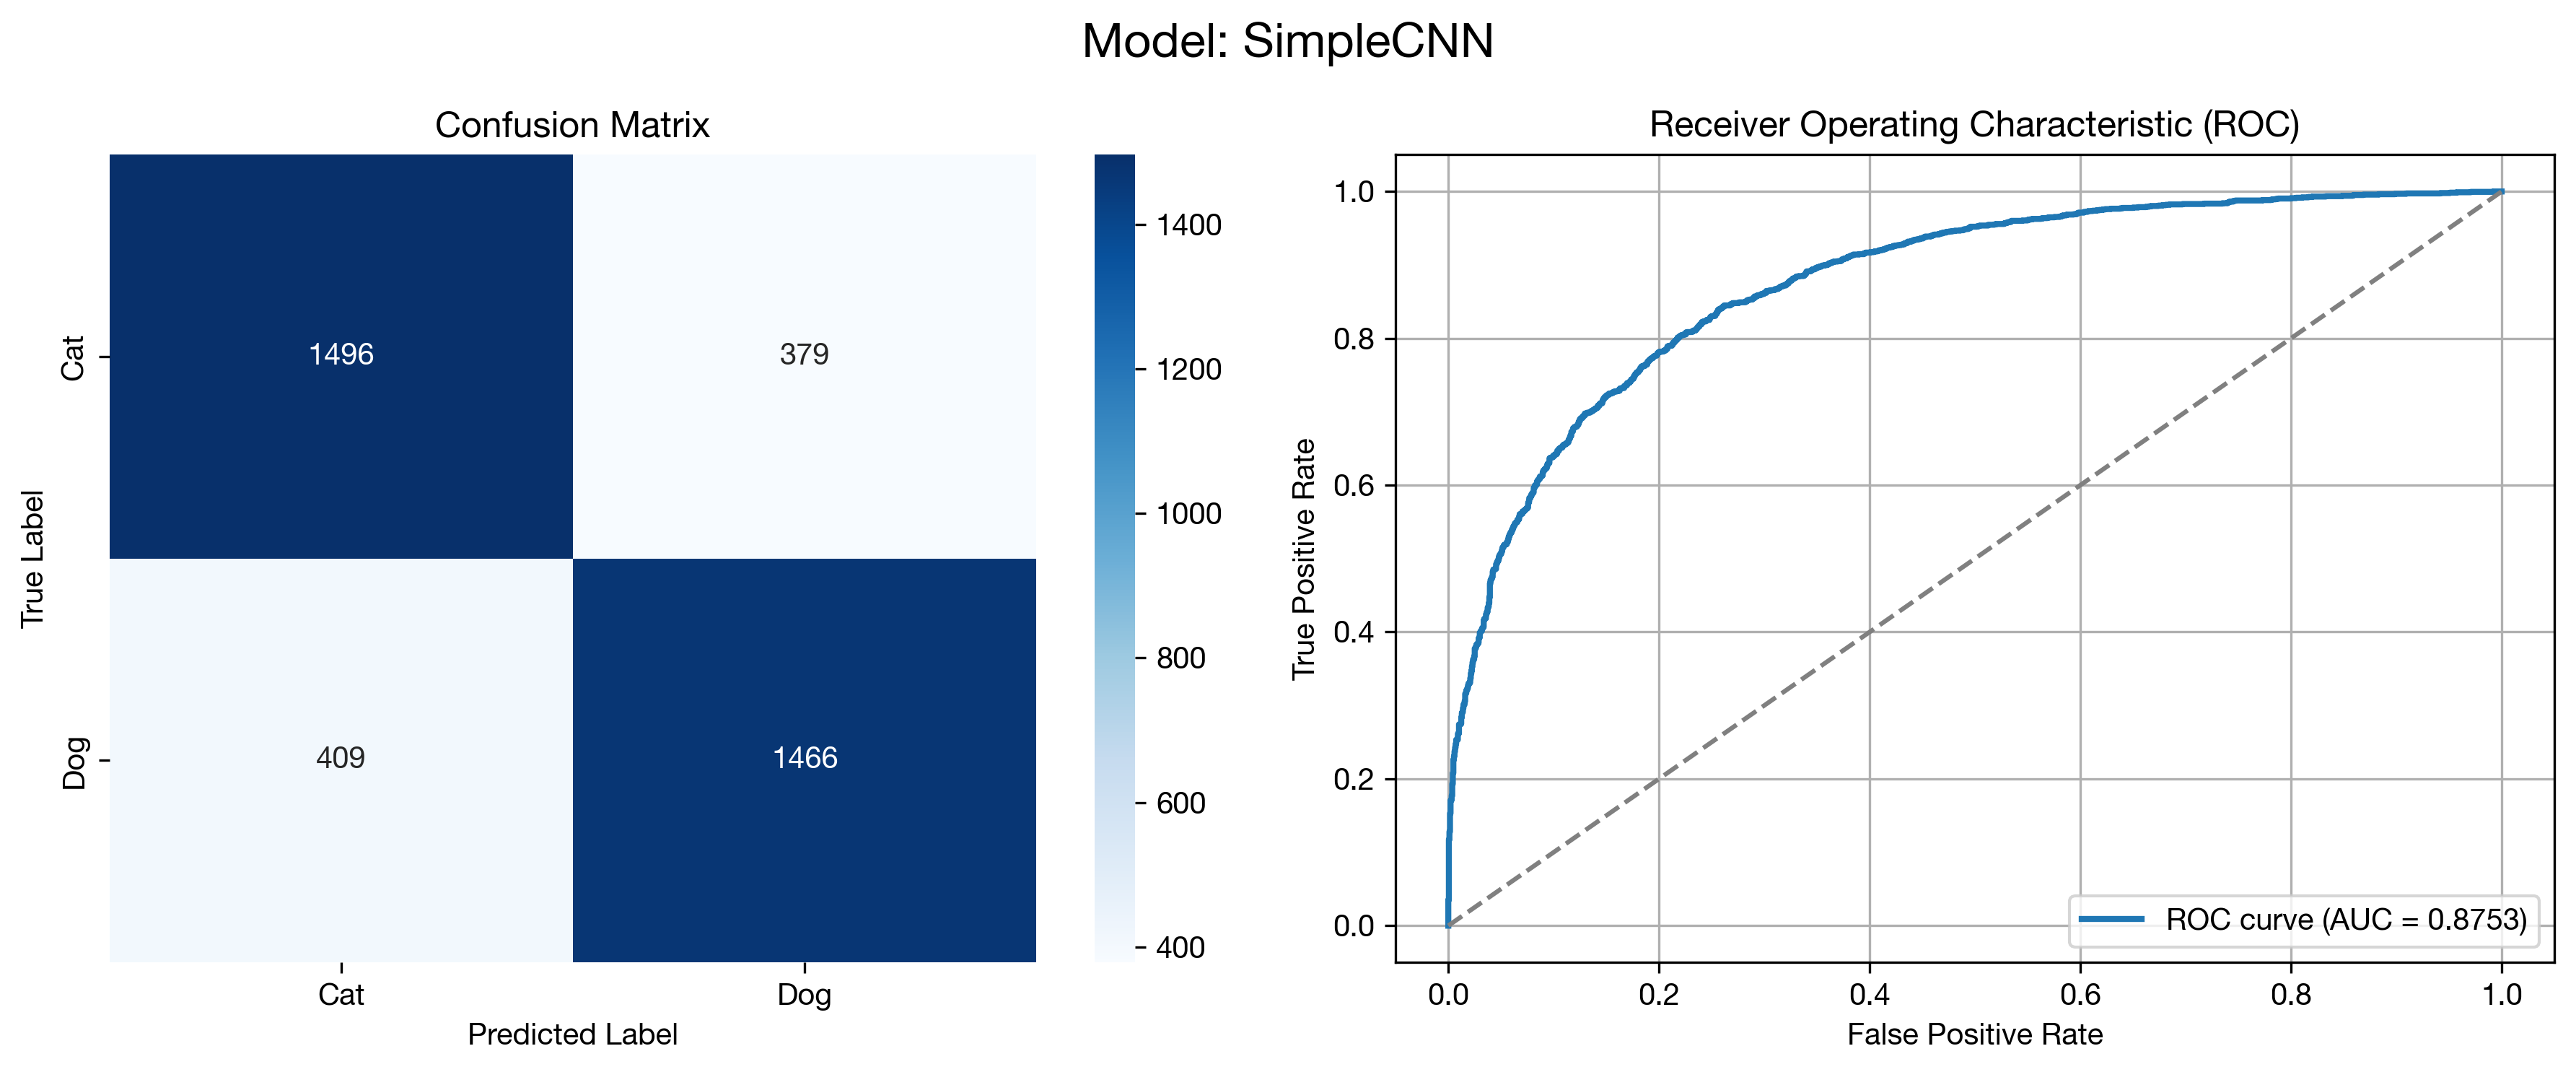

In [31]:
plot_cm_roc(
    all_labels,
    all_preds,
    all_probs,
    title="Model: SimpleCNN",
    filename="metrics_simplecnn.png",
)

In [ ]:
save_classification_report(all_labels, all_preds, "classreport_simplecnn.png")

## Busca por hiperparâmetros usando Optuna

### O que é Optuna?

Optuna é uma biblioteca open-source em Python para otimização automática de hiperparâmetros.
Seu principal objetivo é encontrar as melhores combinações de hiperparâmetros para maximizar (ou minimizar) o desempenho de um modelo, como a acurácia ou a perda de validação.

É muito usada em deep learning, machine learning tradicional, e até em modelos estatísticos, devido à sua eficiência, flexibilidade e facilidade de uso.

### Como o Optuna faz a otimização?

Optuna adota uma abordagem baseada em amostragem inteligente e eficiente, chamada TPE (Tree-structured Parzen Estimator). Com isso, em vez de testar todas as combinações, como o grid search faz, em alto nível, o Optuna:
1. Observa os resultados anteriores
2. Aprende quais regiões do espaço de hiperparâmetros têm melhor desempenho
3. Amostra novas combinações com mais chance de serem boas (exploração + exploração guiada)

Para isso, é necessário algumas etapas:
1. Definição de uma função objetivo
    - Aqui, o modelo é configurado para retornar uma métrica de avaliação (por exemplo, acurácia)
2. Amostragem de hiperparâmetros
    - Onde é realizada a sugestão de valores
3. Execução do treinamento
    - Com os hiperparâmetros sugeridos
4. Avaliação
    - A métrica é usada para guiar os próximos testes
5. Repetição
    - Até o número de trials desejado ou convergência

### Busca

In [69]:
class TuningSimpleCNN(nn.Module):
    def __init__(
        self, dropout=0.5, num_fc_layers=1, hidden_units=512, activation_fn=F.relu
    ):
        super(TuningSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)

        self.dropout = nn.Dropout(dropout)
        self.num_fc_layers = num_fc_layers
        self.activation_fn = activation_fn

        self.fc1 = nn.Linear(128 * 17 * 17, hidden_units)
        if num_fc_layers == 2:
            self.fc2 = nn.Linear(hidden_units, hidden_units)
            self.fc3 = nn.Linear(hidden_units, 1)
        else:
            self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 17 * 17)
        x = self.dropout(self.activation_fn(self.fc1(x)))

        if self.num_fc_layers == 2:
            x = self.dropout(self.activation_fn(self.fc2(x)))
            x = torch.sigmoid(self.fc3(x))
        else:
            x = torch.sigmoid(self.fc2(x))
        return x

In [30]:
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # Architecture search
    num_fc_layers = trial.suggest_categorical("num_fc_layers", [1, 2])
    hidden_units = trial.suggest_categorical("hidden_units", [256, 512, 1024])
    activation_name = trial.suggest_categorical(
        "activation", ["relu", "elu", "leaky_relu"]
    )

    # Map activation name to function
    if activation_name == "relu":
        activation_fn = F.relu
    elif activation_name == "elu":
        activation_fn = F.elu
    else:
        activation_fn = F.leaky_relu

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model and optimizer
    model = TuningSimpleCNN(
        dropout=dropout,
        num_fc_layers=num_fc_layers,
        hidden_units=hidden_units,
        activation_fn=activation_fn,
    ).to(device)

    optimizer = {
        "Adam": torch.optim.Adam(model.parameters(), lr=lr),
        "SGD": torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9),
    }[optimizer_name]

    criterion = nn.BCELoss()

    # Quick training (only 3 epochs)
    for epoch in range(3):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation accuracy
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    acc = accuracy_score(all_labels, all_preds)
    return acc  # Optuna will try to maximize this

In [31]:
sampler = optuna.samplers.TPESampler(seed=12345)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)
study.best_trial

[I 2025-04-13 09:26:48,089] A new study created in memory with name: no-name-a734804f-eeb0-43b9-9cb1-fc09b29366f9
[I 2025-04-13 09:30:01,531] Trial 0 finished with value: 0.612 and parameters: {'lr': 0.006149619971126093, 'dropout': 0.2949126663745358, 'batch_size': 64, 'optimizer': 'SGD', 'num_fc_layers': 2, 'hidden_units': 1024, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.612.
[I 2025-04-13 09:33:12,074] Trial 1 finished with value: 0.5752 and parameters: {'lr': 0.0009316087292291503, 'dropout': 0.44294376576228045, 'batch_size': 32, 'optimizer': 'SGD', 'num_fc_layers': 1, 'hidden_units': 1024, 'activation': 'elu'}. Best is trial 0 with value: 0.612.
[I 2025-04-13 09:36:37,675] Trial 2 finished with value: 0.5 and parameters: {'lr': 1.2037819508916846e-05, 'dropout': 0.4401110731776382, 'batch_size': 16, 'optimizer': 'SGD', 'num_fc_layers': 2, 'hidden_units': 512, 'activation': 'relu'}. Best is trial 0 with value: 0.612.
[I 2025-04-13 09:39:31,790] Trial 3 finished wit

FrozenTrial(number=7, state=1, values=[0.8210666666666666], datetime_start=datetime.datetime(2025, 4, 13, 9, 54, 7, 186771), datetime_complete=datetime.datetime(2025, 4, 13, 9, 58, 32, 694185), params={'lr': 0.0003527601817527632, 'dropout': 0.4068023988974894, 'batch_size': 16, 'optimizer': 'Adam', 'num_fc_layers': 1, 'hidden_units': 512, 'activation': 'elu'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'dropout': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'num_fc_layers': CategoricalDistribution(choices=(1, 2)), 'hidden_units': CategoricalDistribution(choices=(256, 512, 1024)), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu'))}, trial_id=7, value=None)

In [32]:
# Saving optuna study
with open("./optuna/optuna_study.pkl", "wb") as f:
    pickle.dump(study, f)

In [67]:
# Loading optuna study
with open("./optuna/optuna_study.pkl", "rb") as f:
    study = pickle.load(f)

In [34]:
optuna.visualization.plot_optimization_history(study).show()

In [35]:
optuna.visualization.plot_param_importances(study).show()

In [70]:
best_params = study.best_trial.params
activation_map = {"relu": F.relu, "elu": F.elu, "leaky_relu": F.leaky_relu}
activation_fn = activation_map[best_params["activation"]]

# Recreate model
best_model = TuningSimpleCNN(
    dropout=best_params["dropout"],
    num_fc_layers=best_params["num_fc_layers"],
    hidden_units=best_params["hidden_units"],
    activation_fn=activation_fn,
).to(device)

# Optimizer
if best_params["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
else:
    optimizer = torch.optim.SGD(
        best_model.parameters(), lr=best_params["lr"], momentum=0.9
    )

# Loss
criterion = nn.BCELoss()

In [37]:
best_model, best_optuna_reports = train_model(
    best_model, train_loader, val_loader, optimizer, criterion, device, epochs=30
)

Epoch 1 - Train Loss: 0.6264, Train Acc: 64.65%, Val Acc: 72.75%
Epoch 2 - Train Loss: 0.5232, Train Acc: 73.87%, Val Acc: 77.60%
Epoch 3 - Train Loss: 0.4542, Train Acc: 78.50%, Val Acc: 77.33%
Epoch 4 - Train Loss: 0.3874, Train Acc: 82.23%, Val Acc: 81.57%
Epoch 5 - Train Loss: 0.3358, Train Acc: 85.13%, Val Acc: 82.45%
Epoch 6 - Train Loss: 0.2900, Train Acc: 87.53%, Val Acc: 83.55%
Epoch 7 - Train Loss: 0.2353, Train Acc: 90.20%, Val Acc: 83.01%
Epoch 8 - Train Loss: 0.1835, Train Acc: 92.36%, Val Acc: 81.60%
Epoch 9 - Train Loss: 0.1389, Train Acc: 94.41%, Val Acc: 81.89%
Epoch 10 - Train Loss: 0.1002, Train Acc: 96.21%, Val Acc: 81.52%
Epoch 11 - Train Loss: 0.0779, Train Acc: 97.09%, Val Acc: 81.33%
Epoch 12 - Train Loss: 0.0574, Train Acc: 98.01%, Val Acc: 81.76%
Epoch 13 - Train Loss: 0.0469, Train Acc: 98.37%, Val Acc: 80.91%
Epoch 14 - Train Loss: 0.0489, Train Acc: 98.15%, Val Acc: 81.33%
Epoch 15 - Train Loss: 0.0326, Train Acc: 98.75%, Val Acc: 81.95%
Epoch 16 - Train Lo

In [ ]:
# Saving the model and results so we do not have to re-train it everytime
save_outputs(
    best_model,
    "optuna_best_model_final.pt",
    best_optuna_reports,
    "optuna_best_metrics.pkl",
)

In [71]:
# Loading saved model
model = TuningSimpleCNN().to(device)
model_path = os.path.join("models", "optuna_best_model_final.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

TuningSimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=36992, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [72]:
# Loading the saved results
results_path = os.path.join("reports", "optuna_best_metrics.pkl")
with open(results_path, "rb") as f:
    results = pickle.load(f)

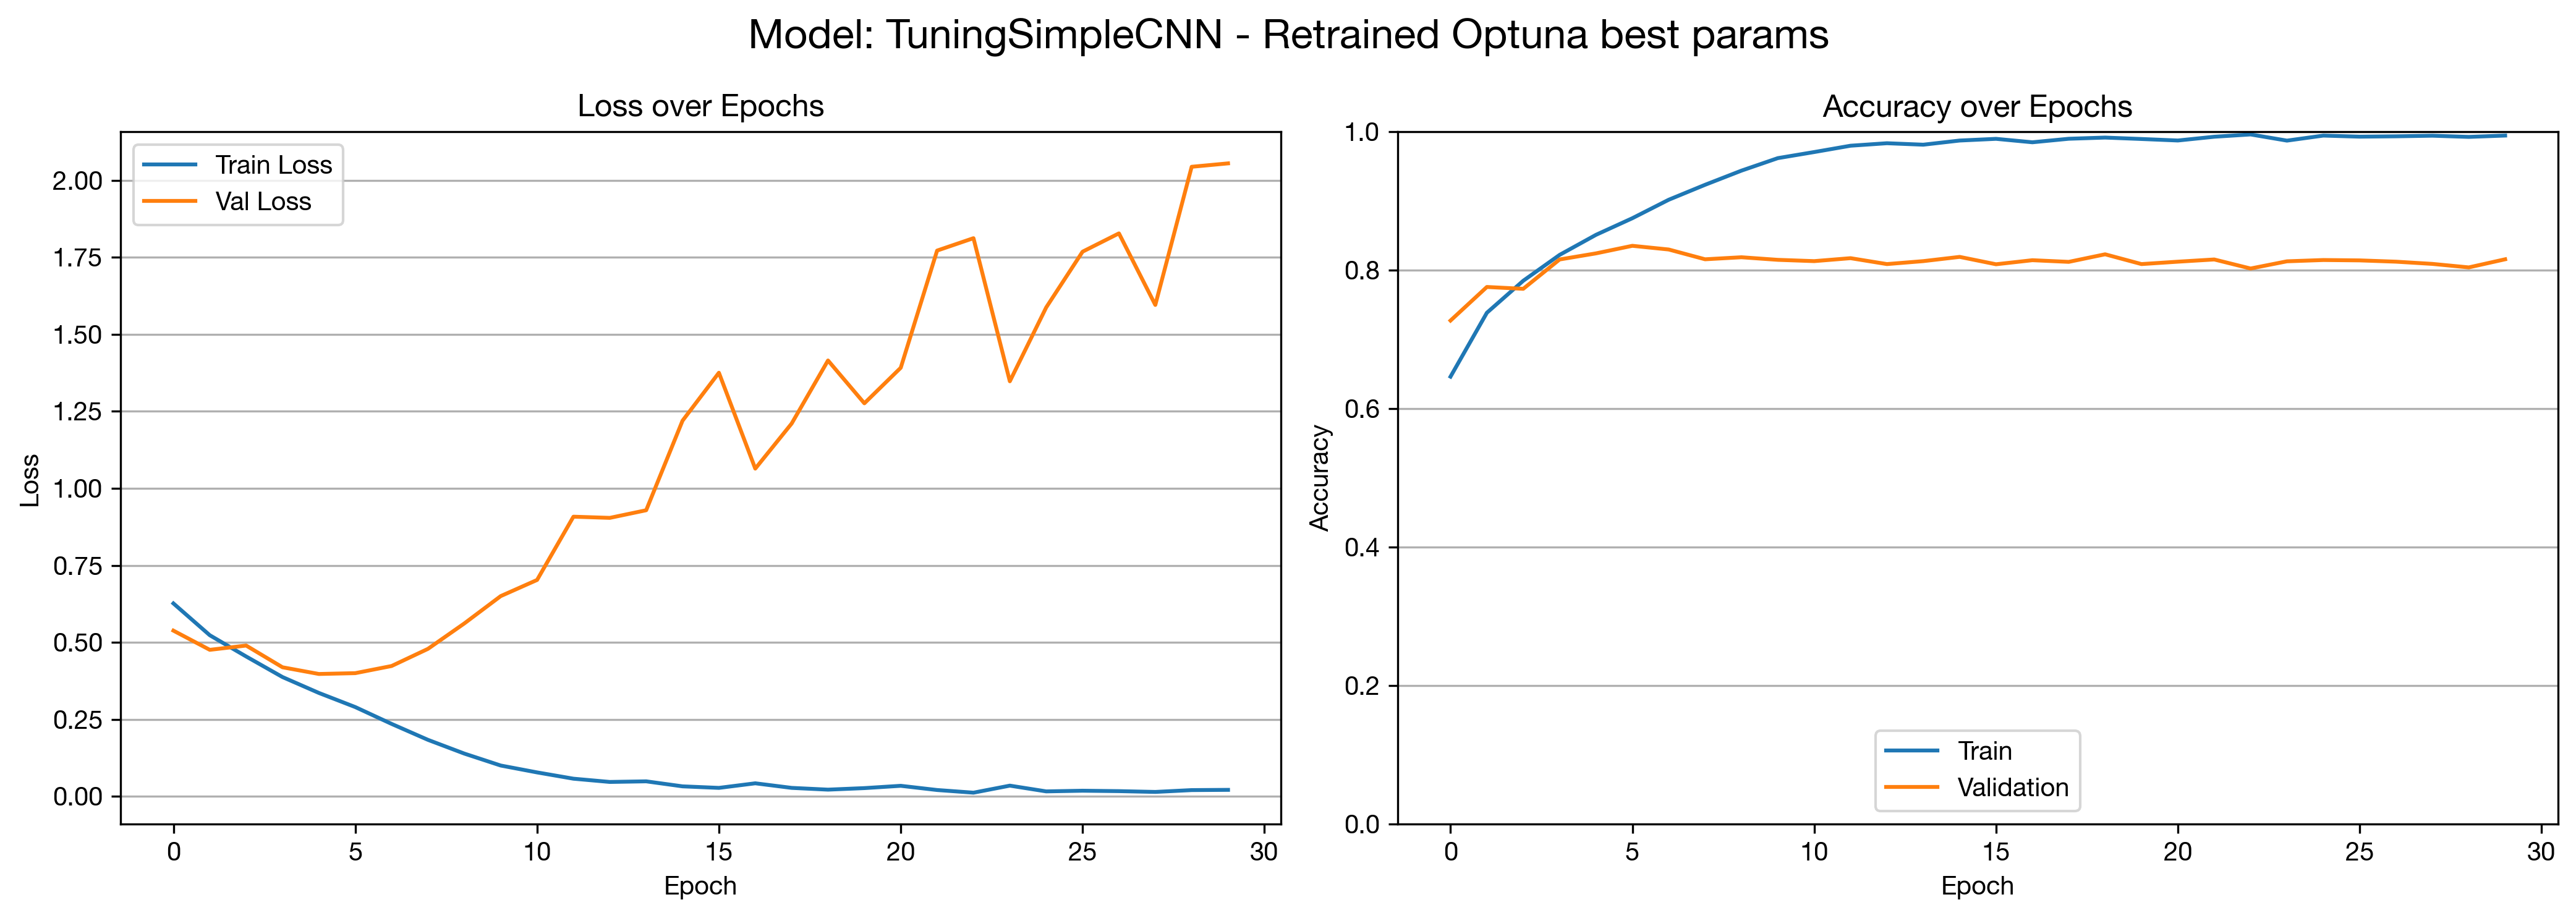

In [ ]:
plot_epochs_graphs(
    results,
    "Model: TuningSimpleCNN - Retrained Optuna best params",
    filename="optuna_epochs.png",
)

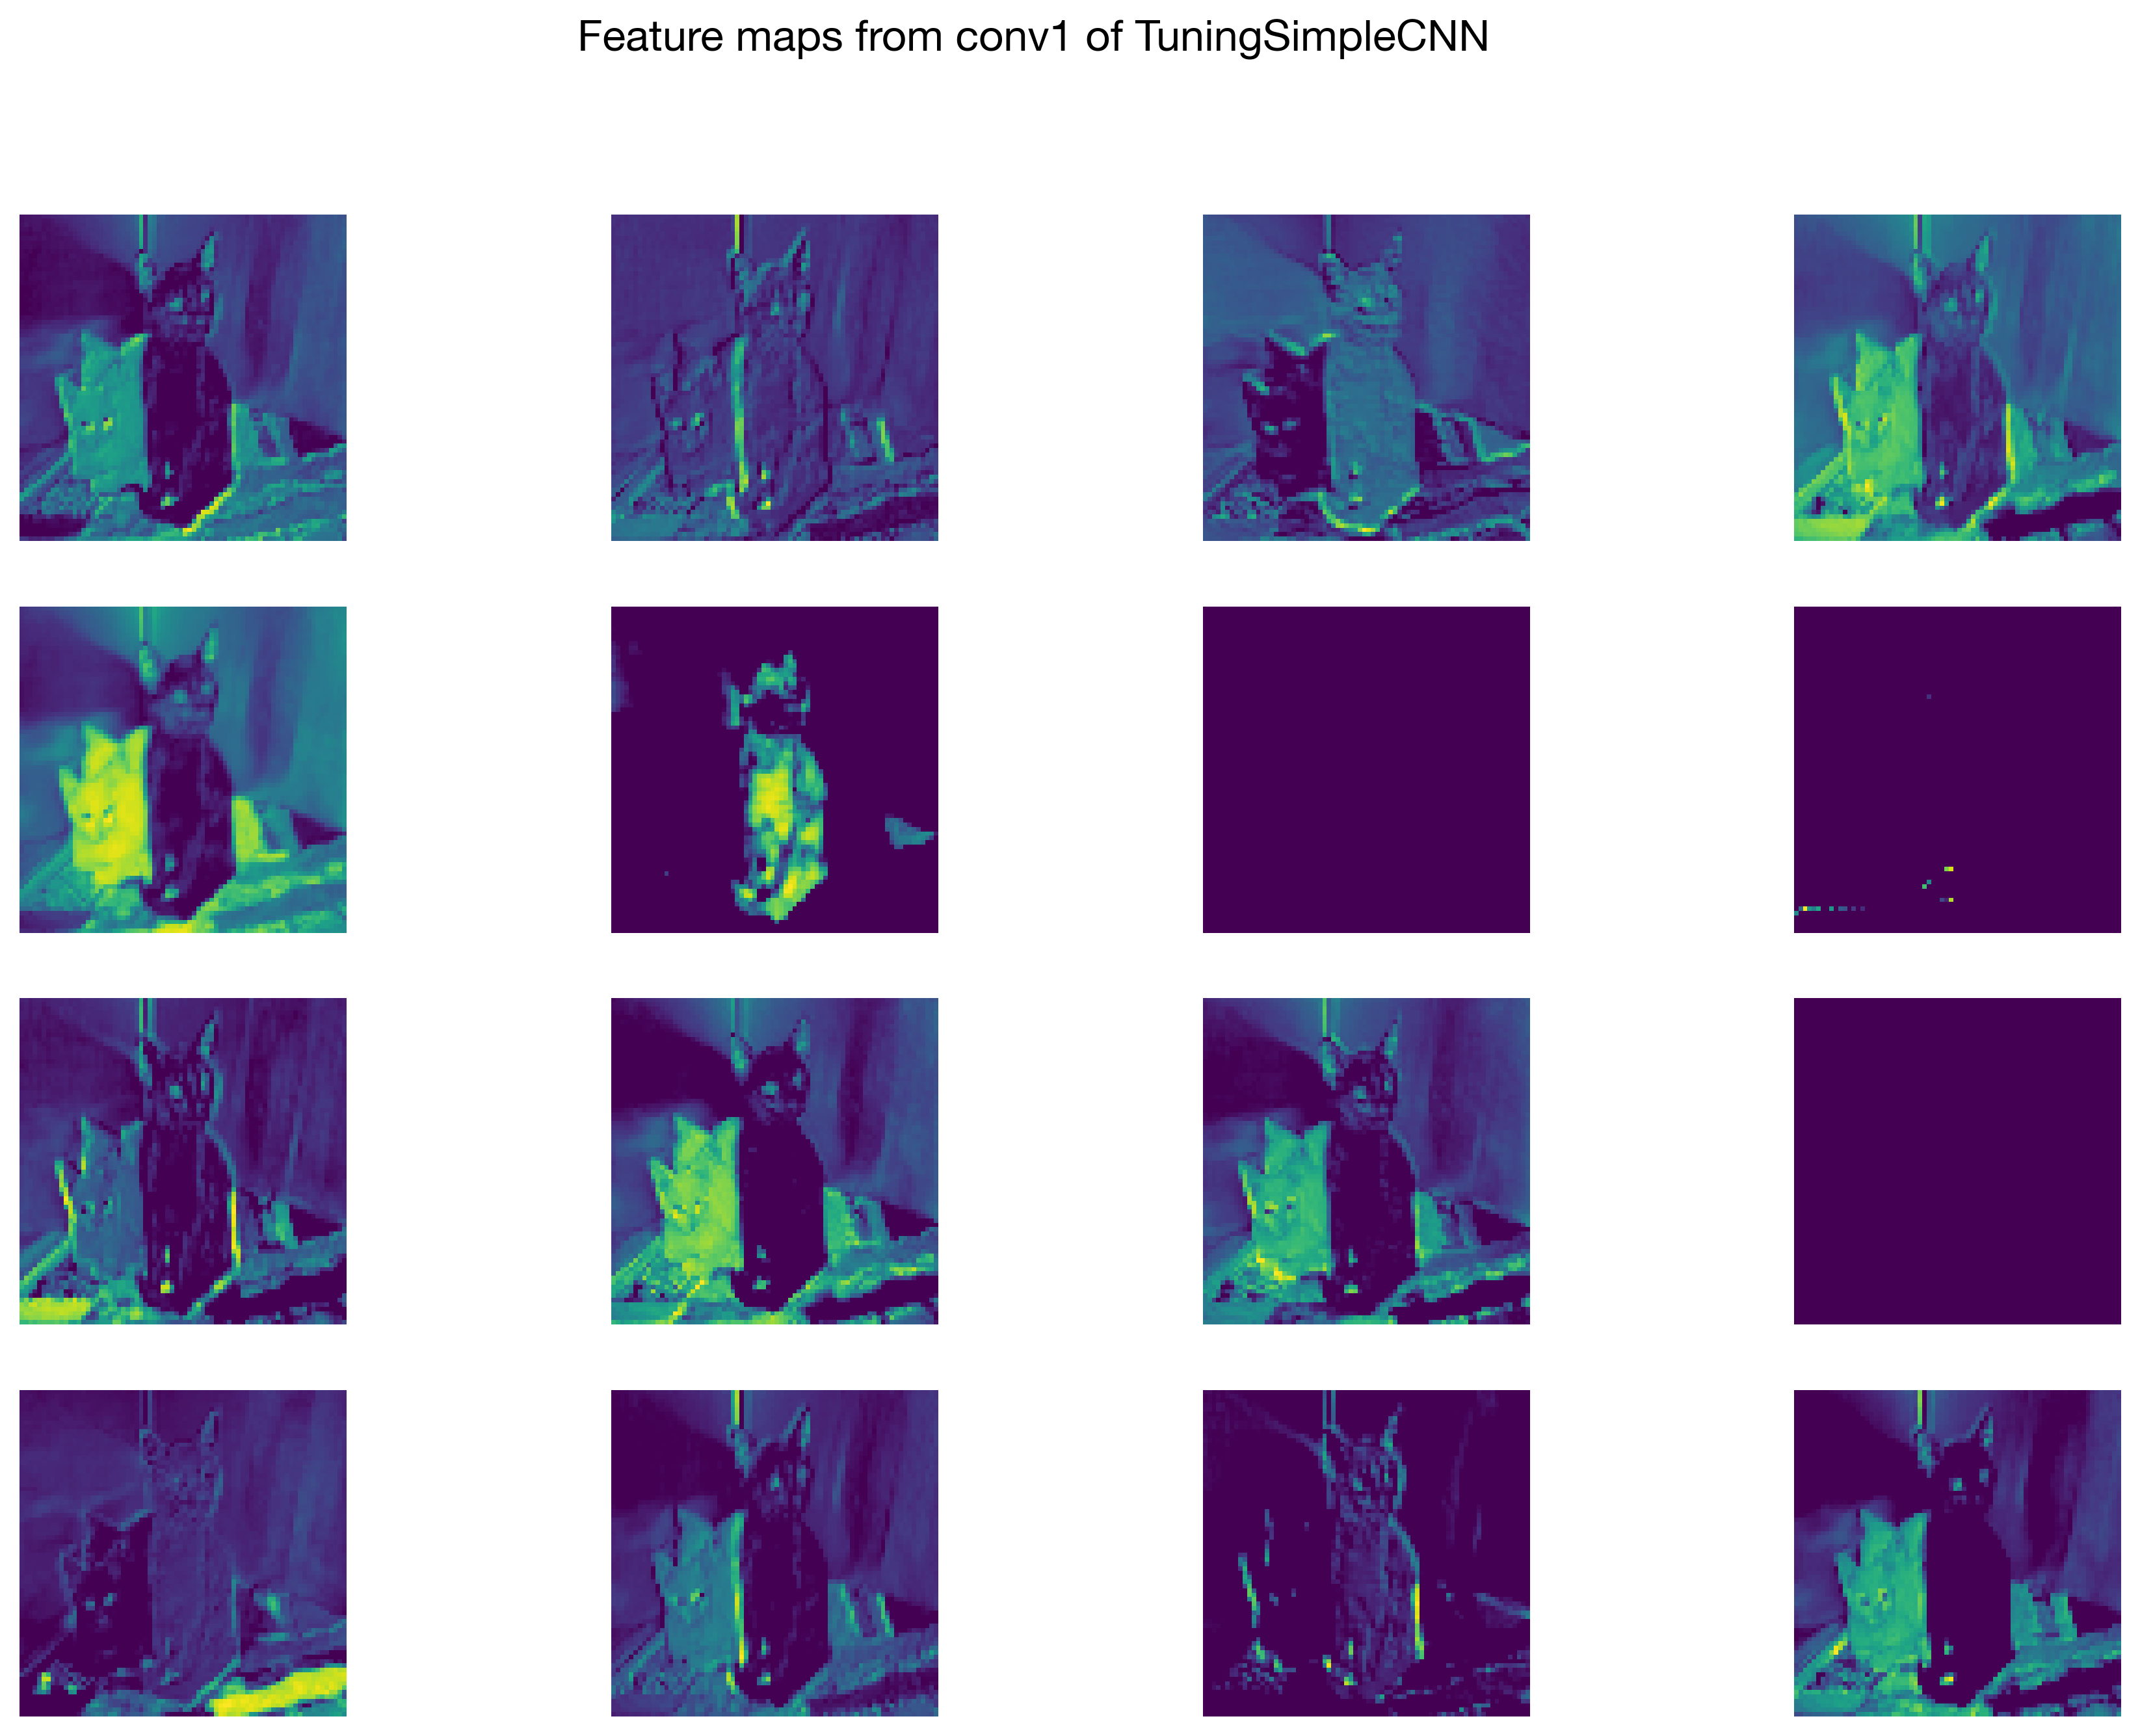

In [ ]:
sample_image, _ = next(iter(test_loader))
visualize_feature_maps(
    model,
    sample_image[0],
    title="Feature maps from conv1 of TuningSimpleCNN",
    filename="fm_optuna.png",
)

In [77]:
all_preds, all_probs, all_labels = get_model_outputs(model, test_loader, device)

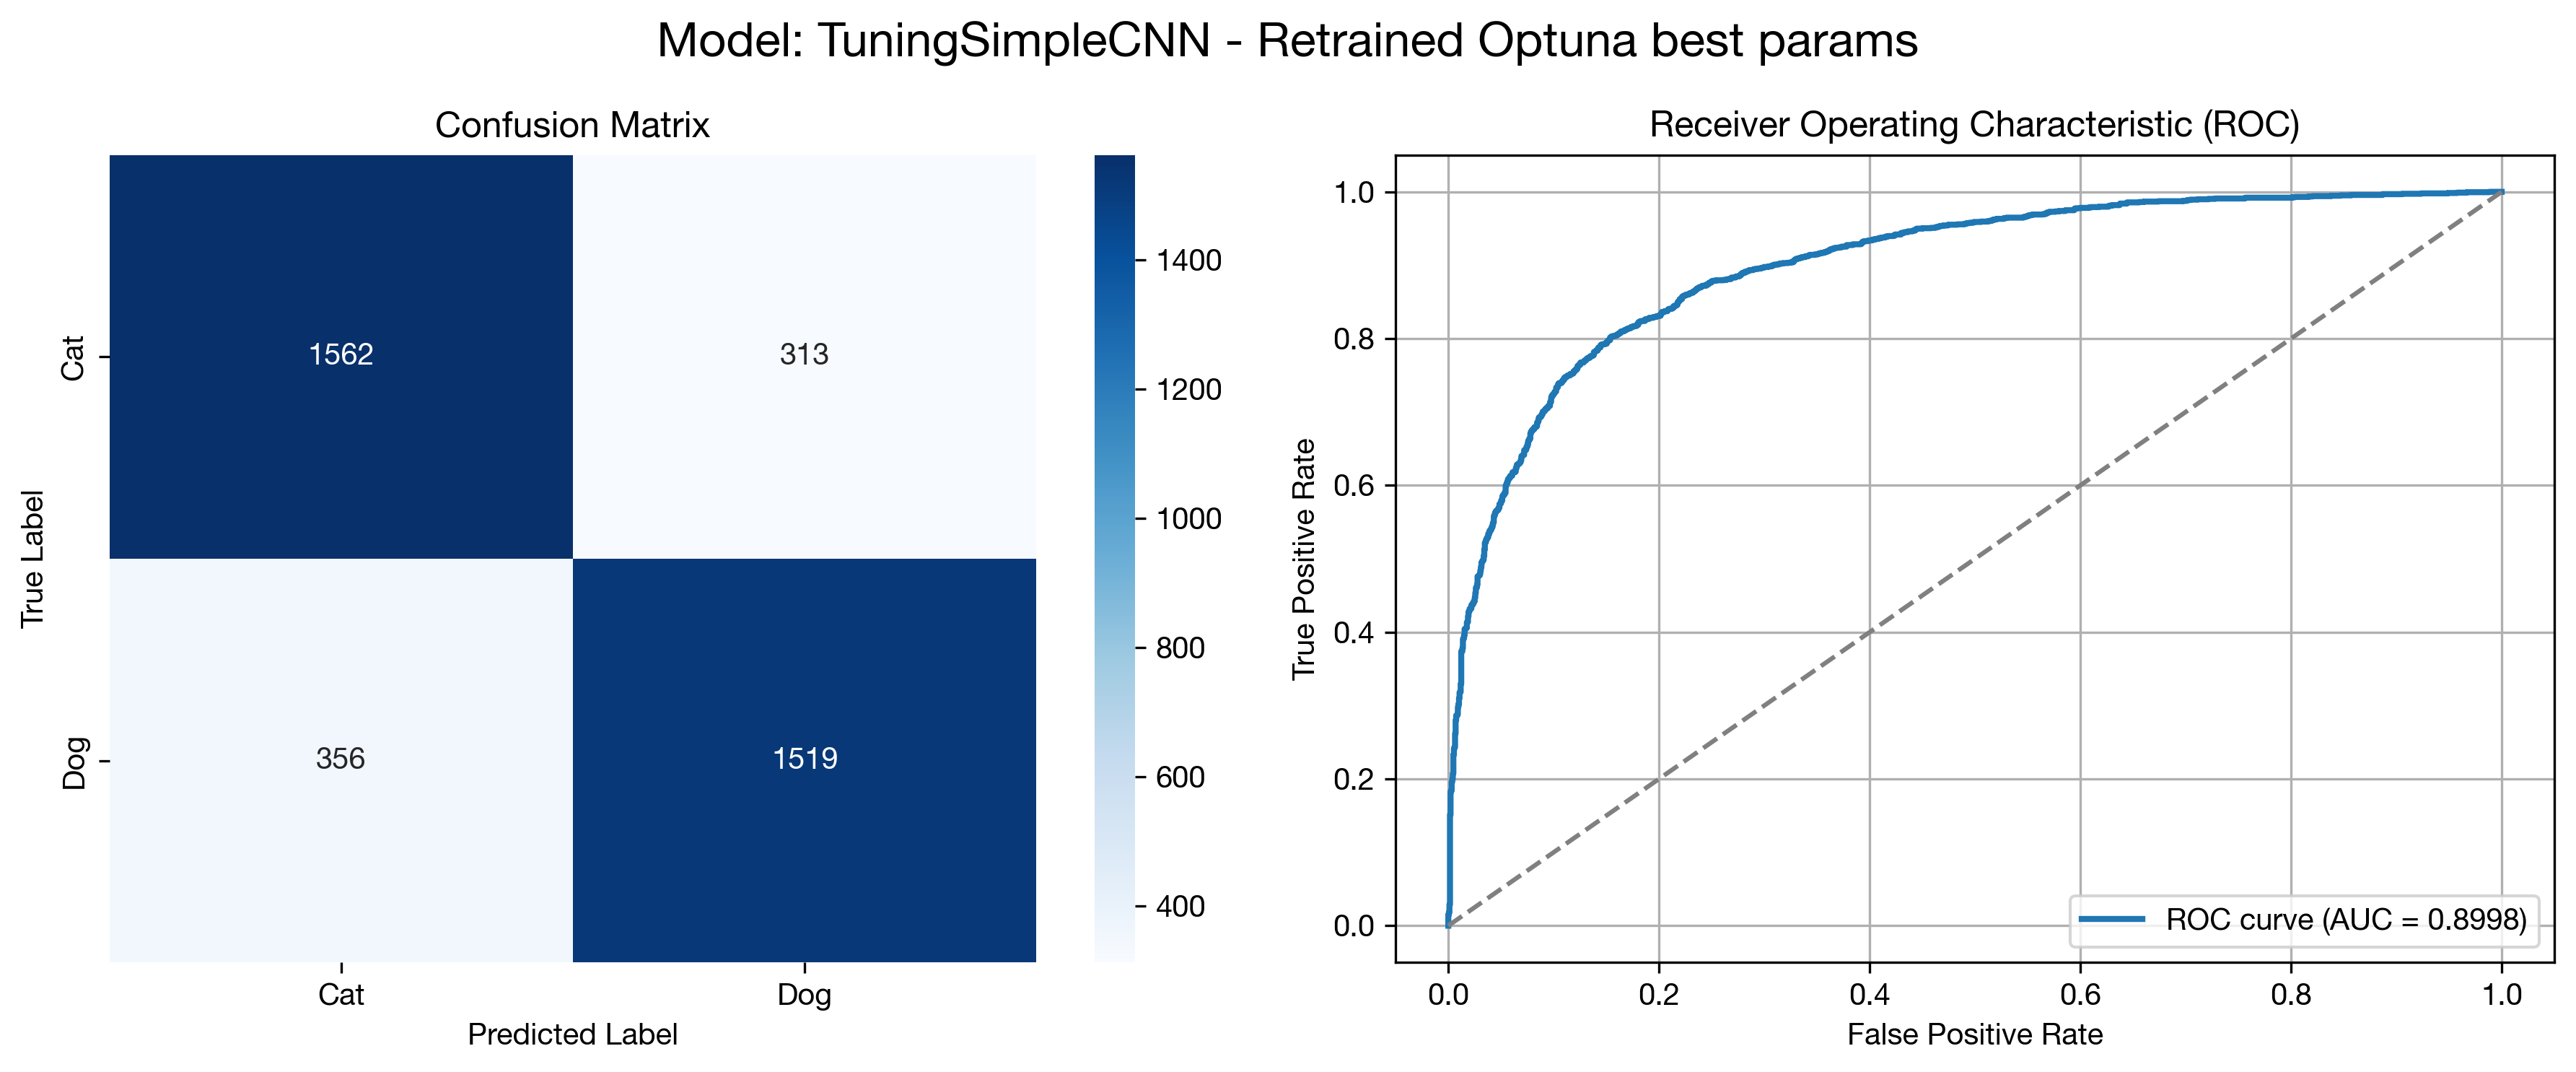

In [ ]:
plot_cm_roc(
    all_labels,
    all_preds,
    all_probs,
    title="Model: TuningSimpleCNN - Retrained Optuna best params",
    filename="metrics_optuna.png",
)

In [ ]:
save_classification_report(all_labels, all_preds, filename="classreport_optuna.png")

## Regularização com batch normalization

Apesar de já estarmos nos utilizando de técnicas de regularização como early stopping e dropout, vamos incluir o batch normalization e ver como isso vai influenciar nos resultados alcançados pela rede. Vamos usar o mesmo modelo reconstruído pelo Optuna, por ter alcançado melhor acurácia que o SimpleCNN. Contanto, iremos incluir uma camada de normalização de batch para cada camada de convolução.

In [82]:
class TuningSimpleCNNWithBN(nn.Module):
    def __init__(
        self, dropout=0.5, num_fc_layers=1, hidden_units=512, activation_fn=F.relu
    ):
        super(TuningSimpleCNNWithBN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.activation_fn = activation_fn
        self.num_fc_layers = num_fc_layers

        self.fc1 = nn.Linear(128 * 17 * 17, hidden_units)
        self.bn_fc1 = nn.BatchNorm1d(hidden_units)

        if num_fc_layers == 2:
            self.fc2 = nn.Linear(hidden_units, hidden_units)
            self.bn_fc2 = nn.BatchNorm1d(hidden_units)
            self.fc3 = nn.Linear(hidden_units, 1)
        else:
            self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))
        x = self.pool(self.activation_fn(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)

        x = self.dropout(self.activation_fn(self.bn_fc1(self.fc1(x))))

        if self.num_fc_layers == 2:
            x = self.dropout(self.activation_fn(self.bn_fc2(self.fc2(x))))
            x = torch.sigmoid(self.fc3(x))
        else:
            x = torch.sigmoid(self.fc2(x))

        return x

In [25]:
best_model = TuningSimpleCNNWithBN(
    dropout=best_params["dropout"],
    num_fc_layers=best_params["num_fc_layers"],
    hidden_units=best_params["hidden_units"],
    activation_fn=activation_fn,
).to(device)

# Optimizer
if best_params["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
else:
    optimizer = torch.optim.SGD(
        best_model.parameters(), lr=best_params["lr"], momentum=0.9
    )

# Loss
criterion = nn.BCELoss()

In [26]:
best_model, optuna_bn_reports = train_model(
    best_model, train_loader, val_loader, optimizer, criterion, device, epochs=30
)

Epoch 1 - Train Loss: 0.5636, Train Acc: 71.13%, Val Acc: 75.47%
Epoch 2 - Train Loss: 0.4472, Train Acc: 79.22%, Val Acc: 80.21%
Epoch 3 - Train Loss: 0.3994, Train Acc: 81.87%, Val Acc: 73.57%
Epoch 4 - Train Loss: 0.3714, Train Acc: 83.34%, Val Acc: 79.95%
Epoch 5 - Train Loss: 0.3307, Train Acc: 85.58%, Val Acc: 80.93%
Epoch 6 - Train Loss: 0.2945, Train Acc: 87.11%, Val Acc: 82.08%
Epoch 7 - Train Loss: 0.2467, Train Acc: 89.55%, Val Acc: 78.88%
Epoch 8 - Train Loss: 0.1950, Train Acc: 91.78%, Val Acc: 76.53%
Epoch 9 - Train Loss: 0.1464, Train Acc: 94.31%, Val Acc: 81.36%
Epoch 10 - Train Loss: 0.1224, Train Acc: 95.22%, Val Acc: 81.25%
Epoch 11 - Train Loss: 0.0962, Train Acc: 96.37%, Val Acc: 81.04%
Epoch 12 - Train Loss: 0.0847, Train Acc: 96.87%, Val Acc: 81.84%
Epoch 13 - Train Loss: 0.0669, Train Acc: 97.35%, Val Acc: 82.29%
Epoch 14 - Train Loss: 0.0633, Train Acc: 97.67%, Val Acc: 80.00%
Epoch 15 - Train Loss: 0.0530, Train Acc: 98.01%, Val Acc: 80.77%
Epoch 16 - Train Lo

In [ ]:
save_outputs(best_model, "optuna_bn.pt", optuna_bn_reports, "optuna_bn.pkl")

# Saving the model and results so we do not have to re-train it everytime
torch.save(best_model.state_dict(), os.path.join("models", "optuna_bn.pt"))

with open(os.path.join("reports", "optuna_bn.pkl"), "wb") as f:
    pickle.dump(
        {
            "train_losses": optuna_bn_reports["train_losses"],
            "train_accuracies": optuna_bn_reports["train_accuracies"],
            "val_losses": optuna_bn_reports["val_losses"],
            "val_accuracies": optuna_bn_reports["val_accuracies"],
        },
        f,
    )

In [83]:
# Loading saved model
model = TuningSimpleCNNWithBN().to(device)
model_path = os.path.join("models", "optuna_bn.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

# Loading the results
with open("reports/optuna_bn.pkl", "rb") as f:
    optuna_bn_reports = pickle.load(f)

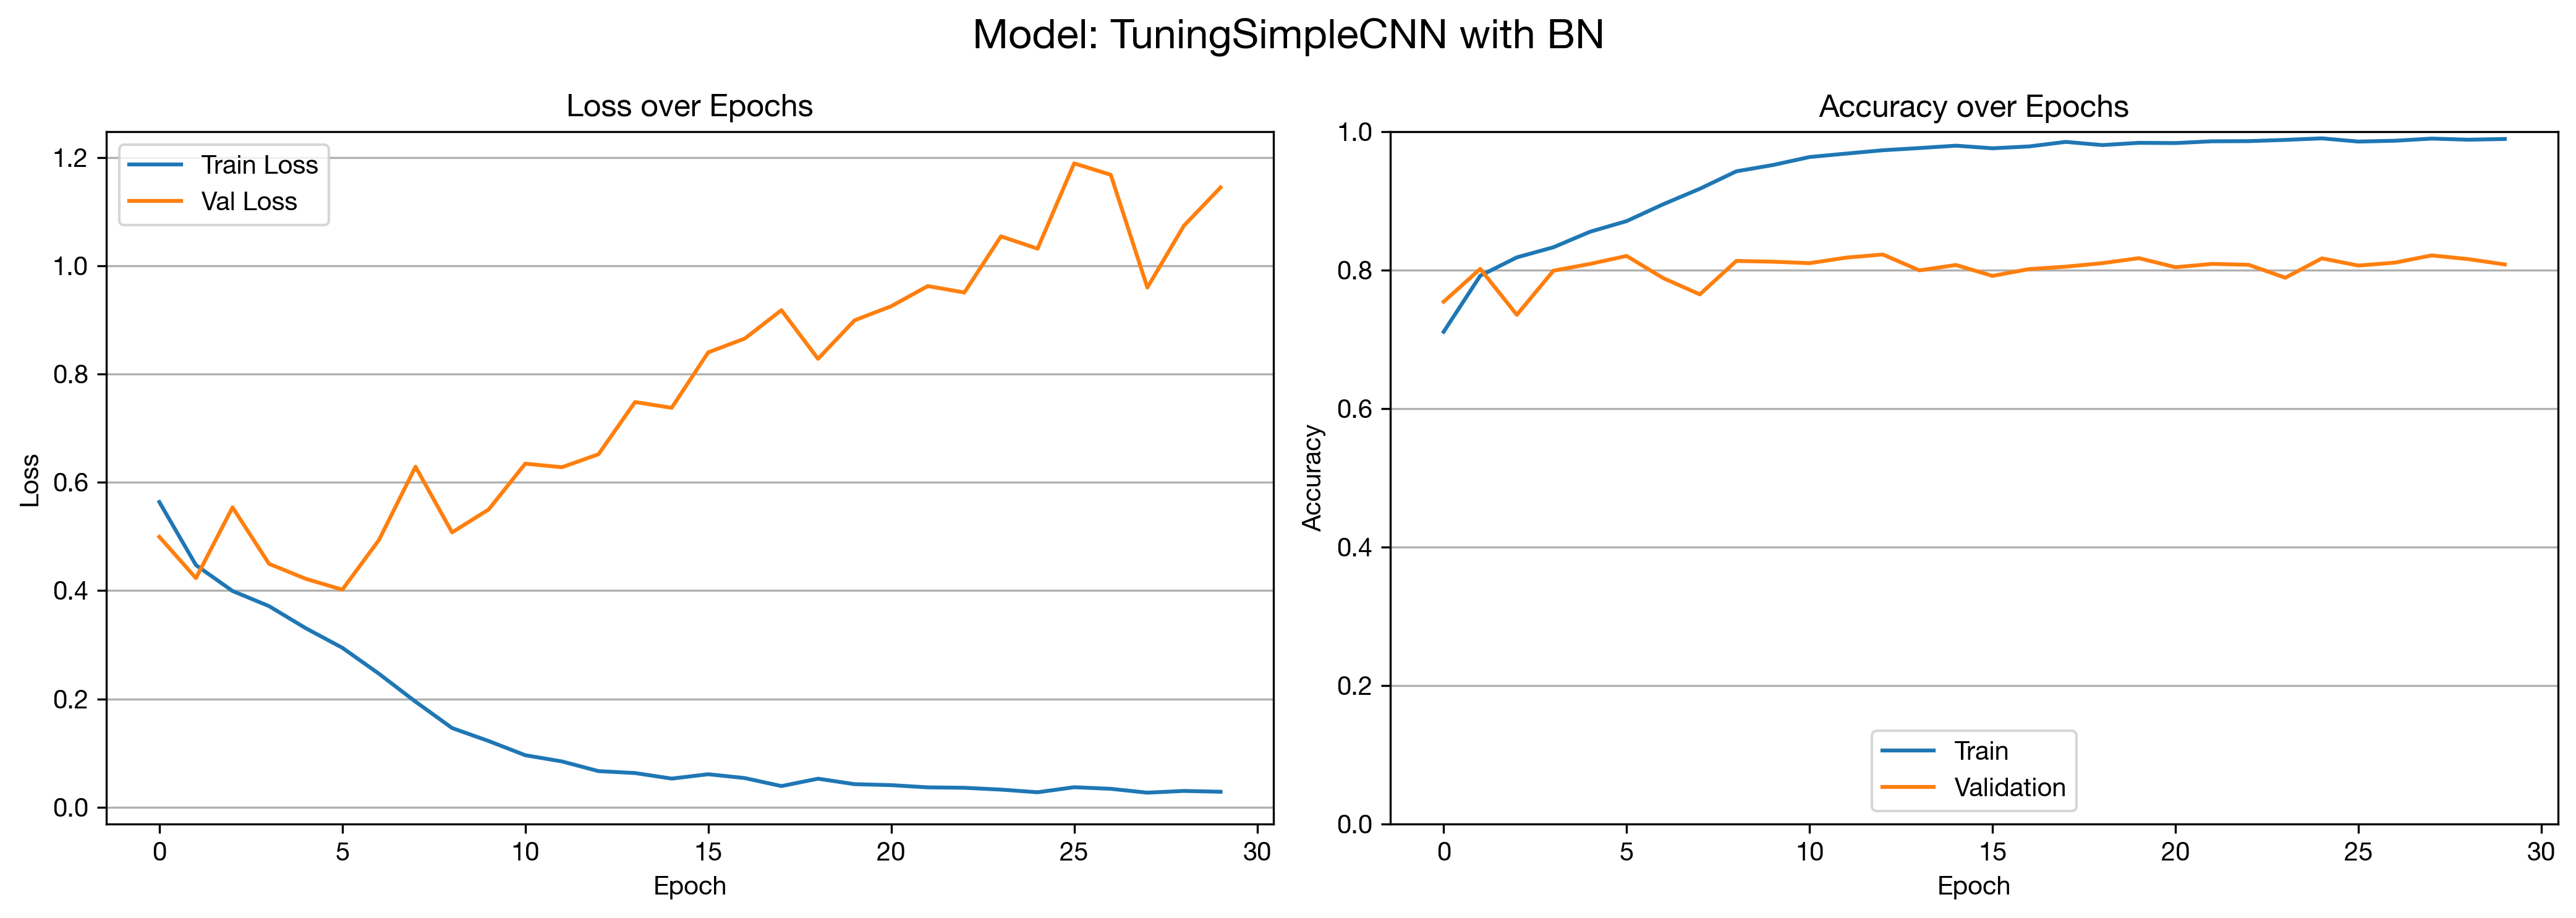

In [ ]:
plot_epochs_graphs(
    optuna_bn_reports,
    title="Model: TuningSimpleCNN with BN",
    filename="optuna_bn_epochs.png",
)

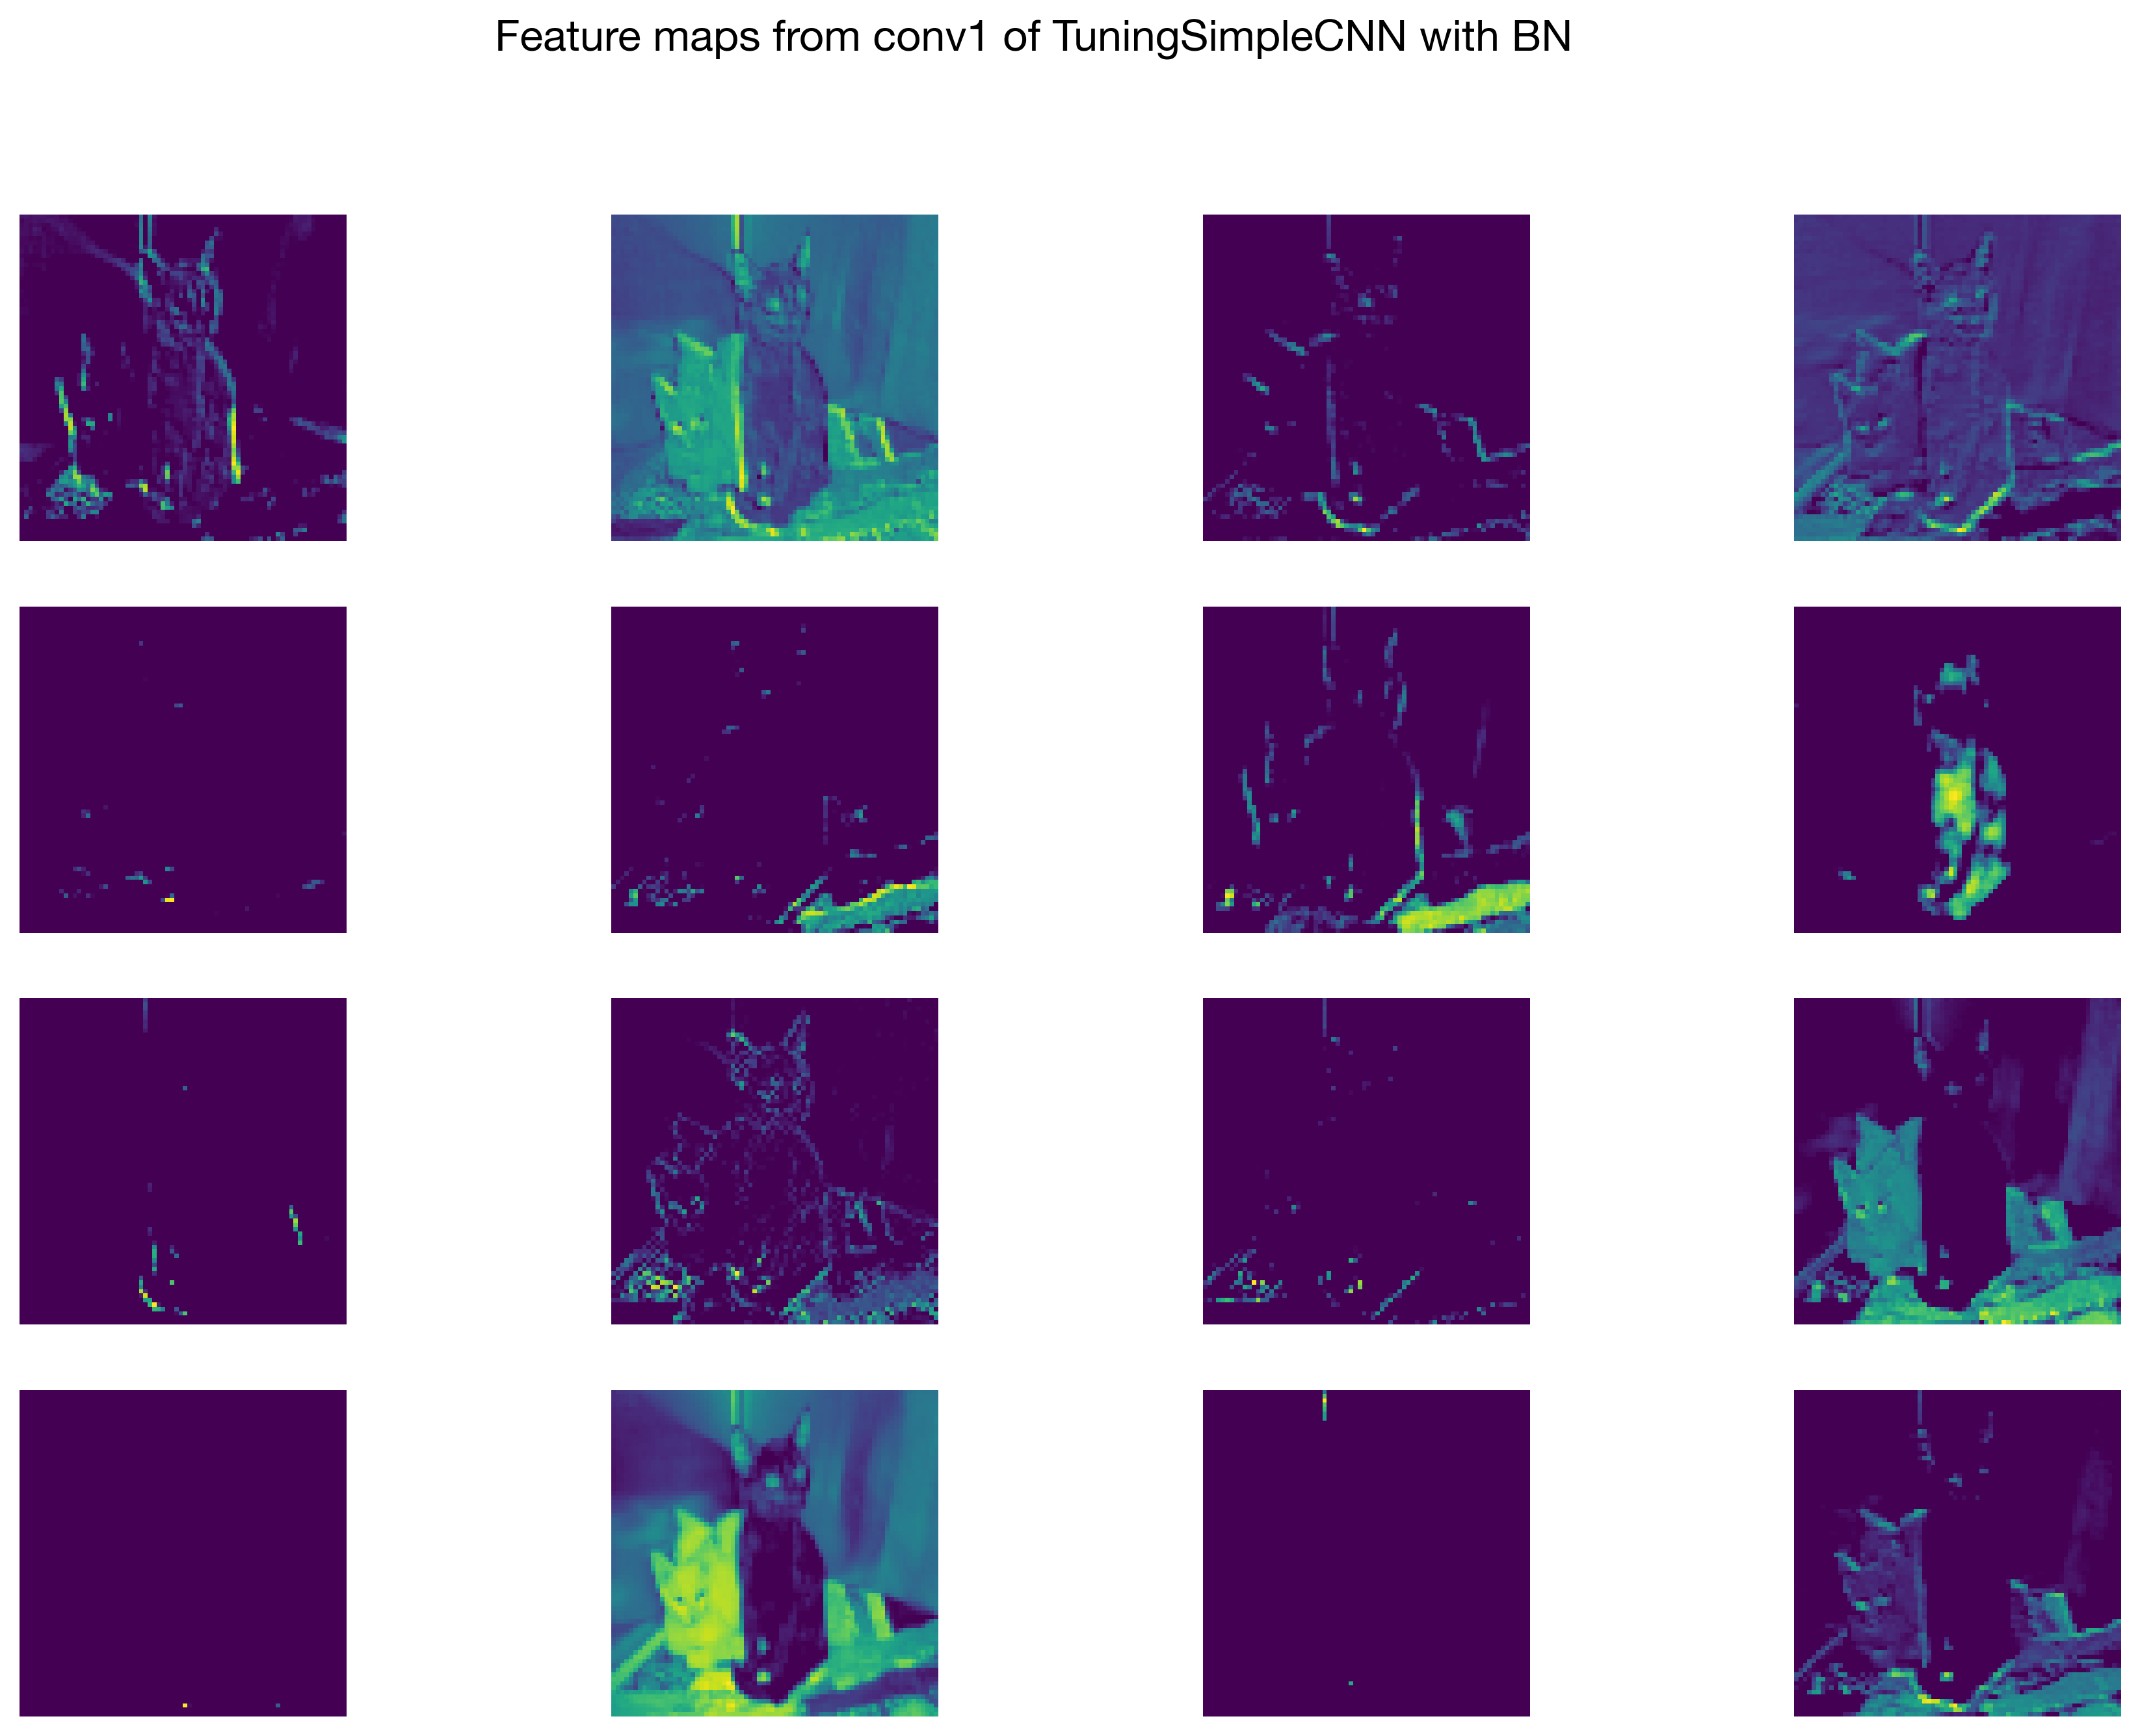

In [86]:
sample_image, _ = next(iter(test_loader))
visualize_feature_maps(
    model,
    sample_image[0],
    title="Feature maps from conv1 of TuningSimpleCNN with BN",
    filename="fm_optuna_bn.png",
)

In [87]:
all_preds, all_probs, all_labels = get_model_outputs(model, test_loader, device)

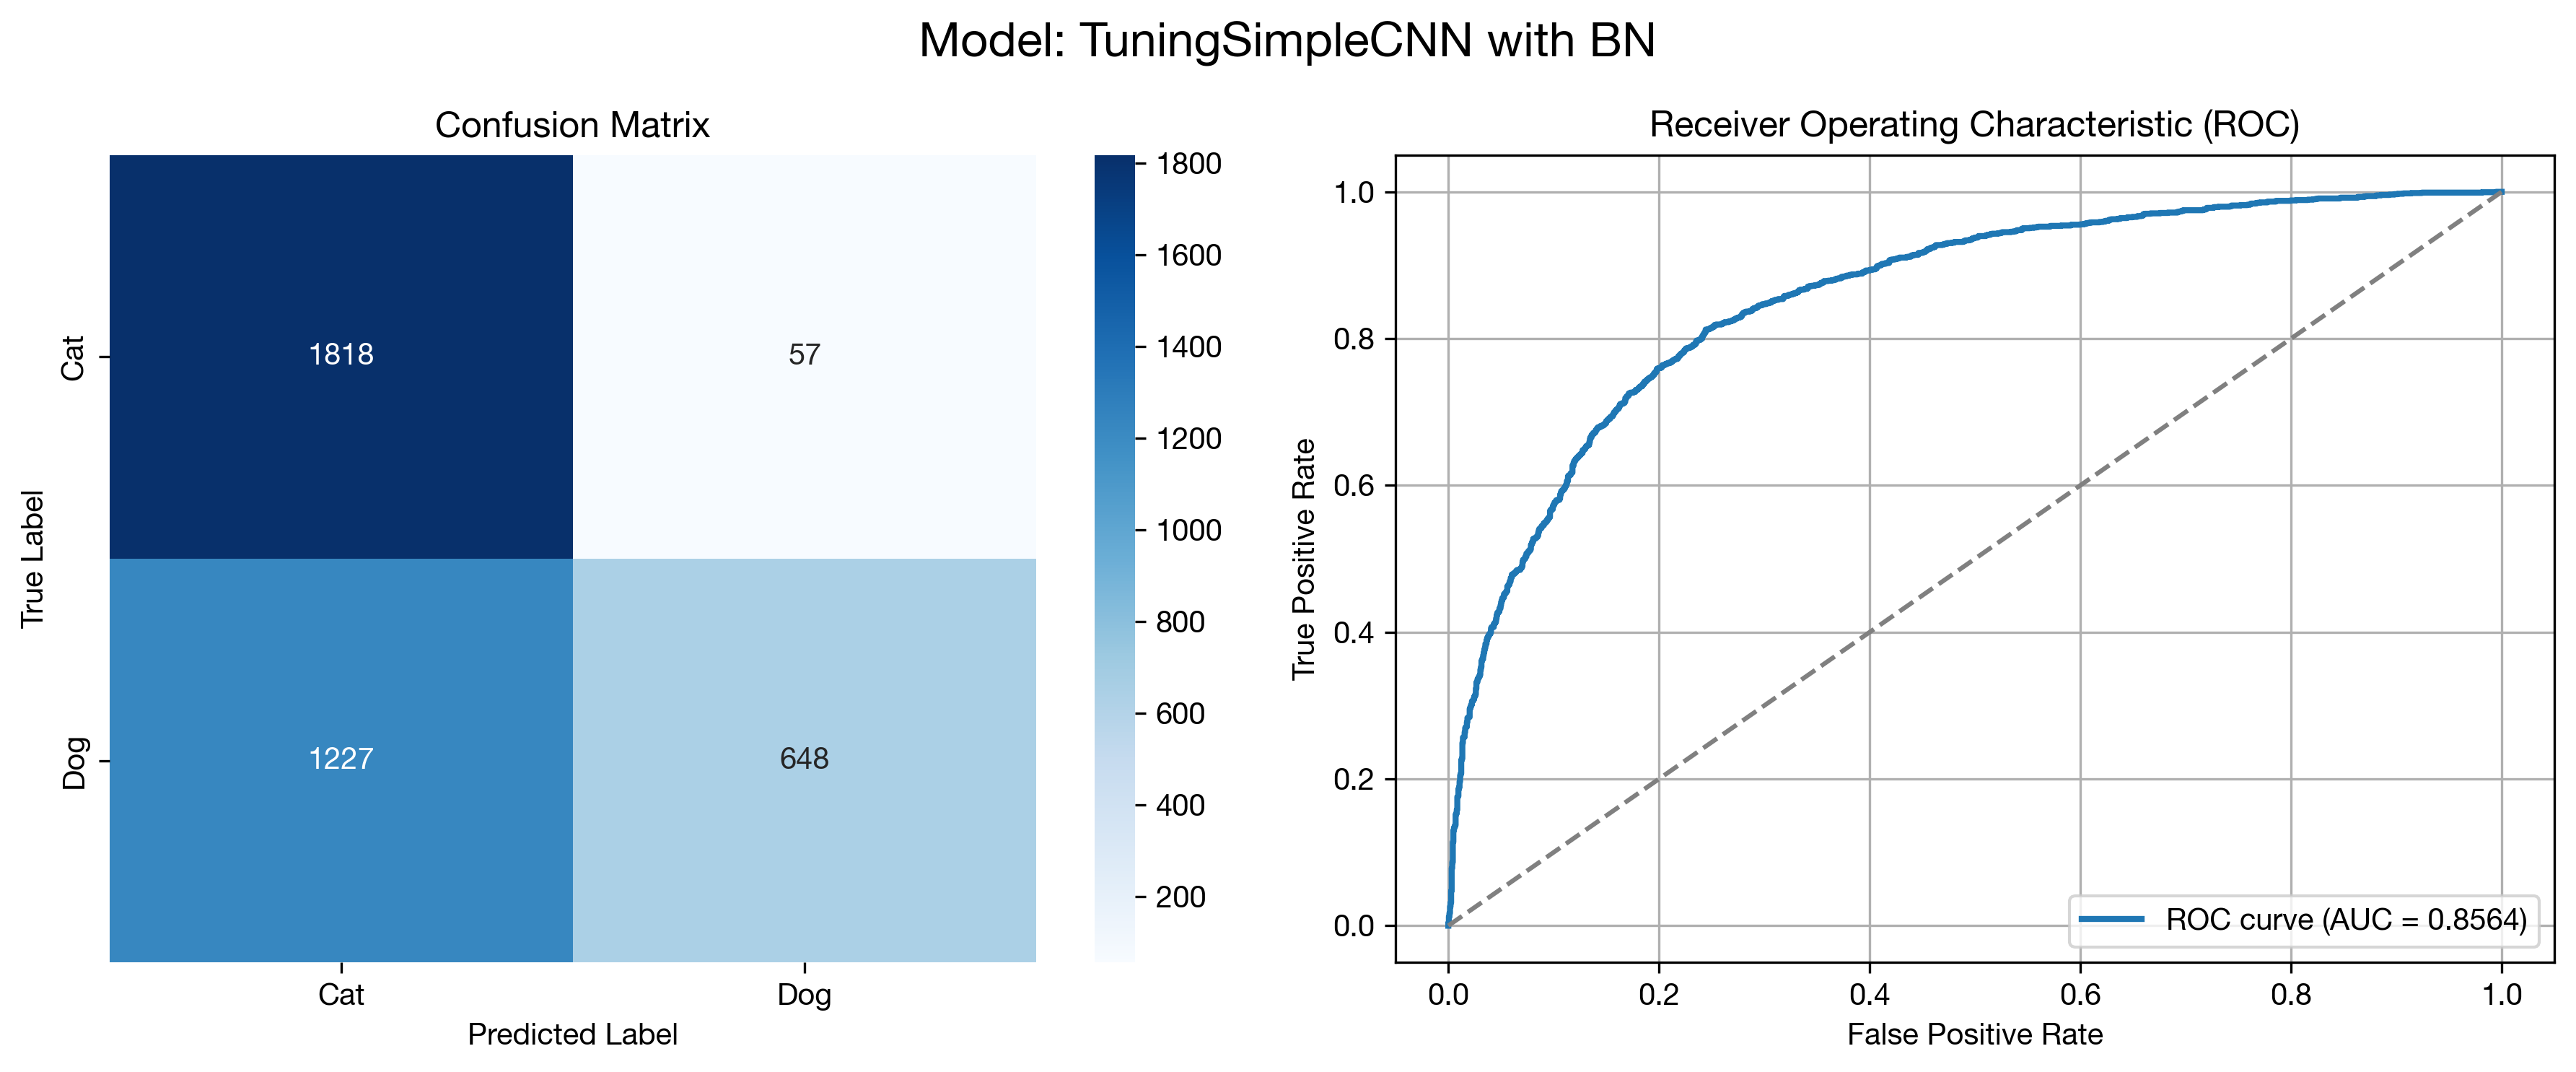

In [ ]:
plot_cm_roc(
    all_labels,
    all_preds,
    all_probs,
    title="Model: TuningSimpleCNN with BN",
    filename="metrics_optuna_bn.png",
)

In [ ]:
save_classification_report(all_labels, all_preds, filename="classreport_optuna_bn.png")

## Rede pré-treinada ResNet: Transfer Learning

In [90]:
# Load resnet18 with imagenet weights
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
resnet = resnet.to(device)

In [91]:
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True

In [92]:
transform_resnet = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # Mean of ImageNet
            std=[0.229, 0.224, 0.225],  # std of ImageNet
        ),
    ]
)

In [55]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-3)

resnet_model, resnet_reports = train_model(
    model=resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=30,
)

Epoch 1 - Train Loss: 0.2243, Train Acc: 90.57%, Val Acc: 94.16%
Epoch 2 - Train Loss: 0.1589, Train Acc: 93.57%, Val Acc: 94.40%
Epoch 3 - Train Loss: 0.1486, Train Acc: 93.73%, Val Acc: 94.61%
Epoch 4 - Train Loss: 0.1455, Train Acc: 93.92%, Val Acc: 94.69%
Epoch 5 - Train Loss: 0.1423, Train Acc: 94.07%, Val Acc: 94.75%
Epoch 6 - Train Loss: 0.1390, Train Acc: 94.17%, Val Acc: 94.85%
Epoch 7 - Train Loss: 0.1372, Train Acc: 94.29%, Val Acc: 94.91%
Epoch 8 - Train Loss: 0.1348, Train Acc: 94.40%, Val Acc: 94.83%
Epoch 9 - Train Loss: 0.1357, Train Acc: 94.21%, Val Acc: 94.80%
Epoch 10 - Train Loss: 0.1345, Train Acc: 94.45%, Val Acc: 95.17%
Epoch 11 - Train Loss: 0.1332, Train Acc: 94.61%, Val Acc: 95.31%
Epoch 12 - Train Loss: 0.1329, Train Acc: 94.58%, Val Acc: 94.91%
Epoch 13 - Train Loss: 0.1309, Train Acc: 94.57%, Val Acc: 95.25%
Epoch 14 - Train Loss: 0.1350, Train Acc: 94.57%, Val Acc: 95.31%
Epoch 15 - Train Loss: 0.1310, Train Acc: 94.55%, Val Acc: 94.88%
Epoch 16 - Train Lo

In [ ]:
save_outputs(resnet_model, "resnet_transfer.pt", resnet_reports, "resnet_transfer.tkl")

In [93]:
model = models.resnet18(weights=None)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1), nn.Sigmoid())
model.load_state_dict(torch.load("models/resnet_transfer.pt"))
resnet_loaded = model.to(device)
resnet_loaded.eval()

with open("reports/resnet_transfer.pkl", "rb") as f:
    resnet_reports = pickle.load(f)

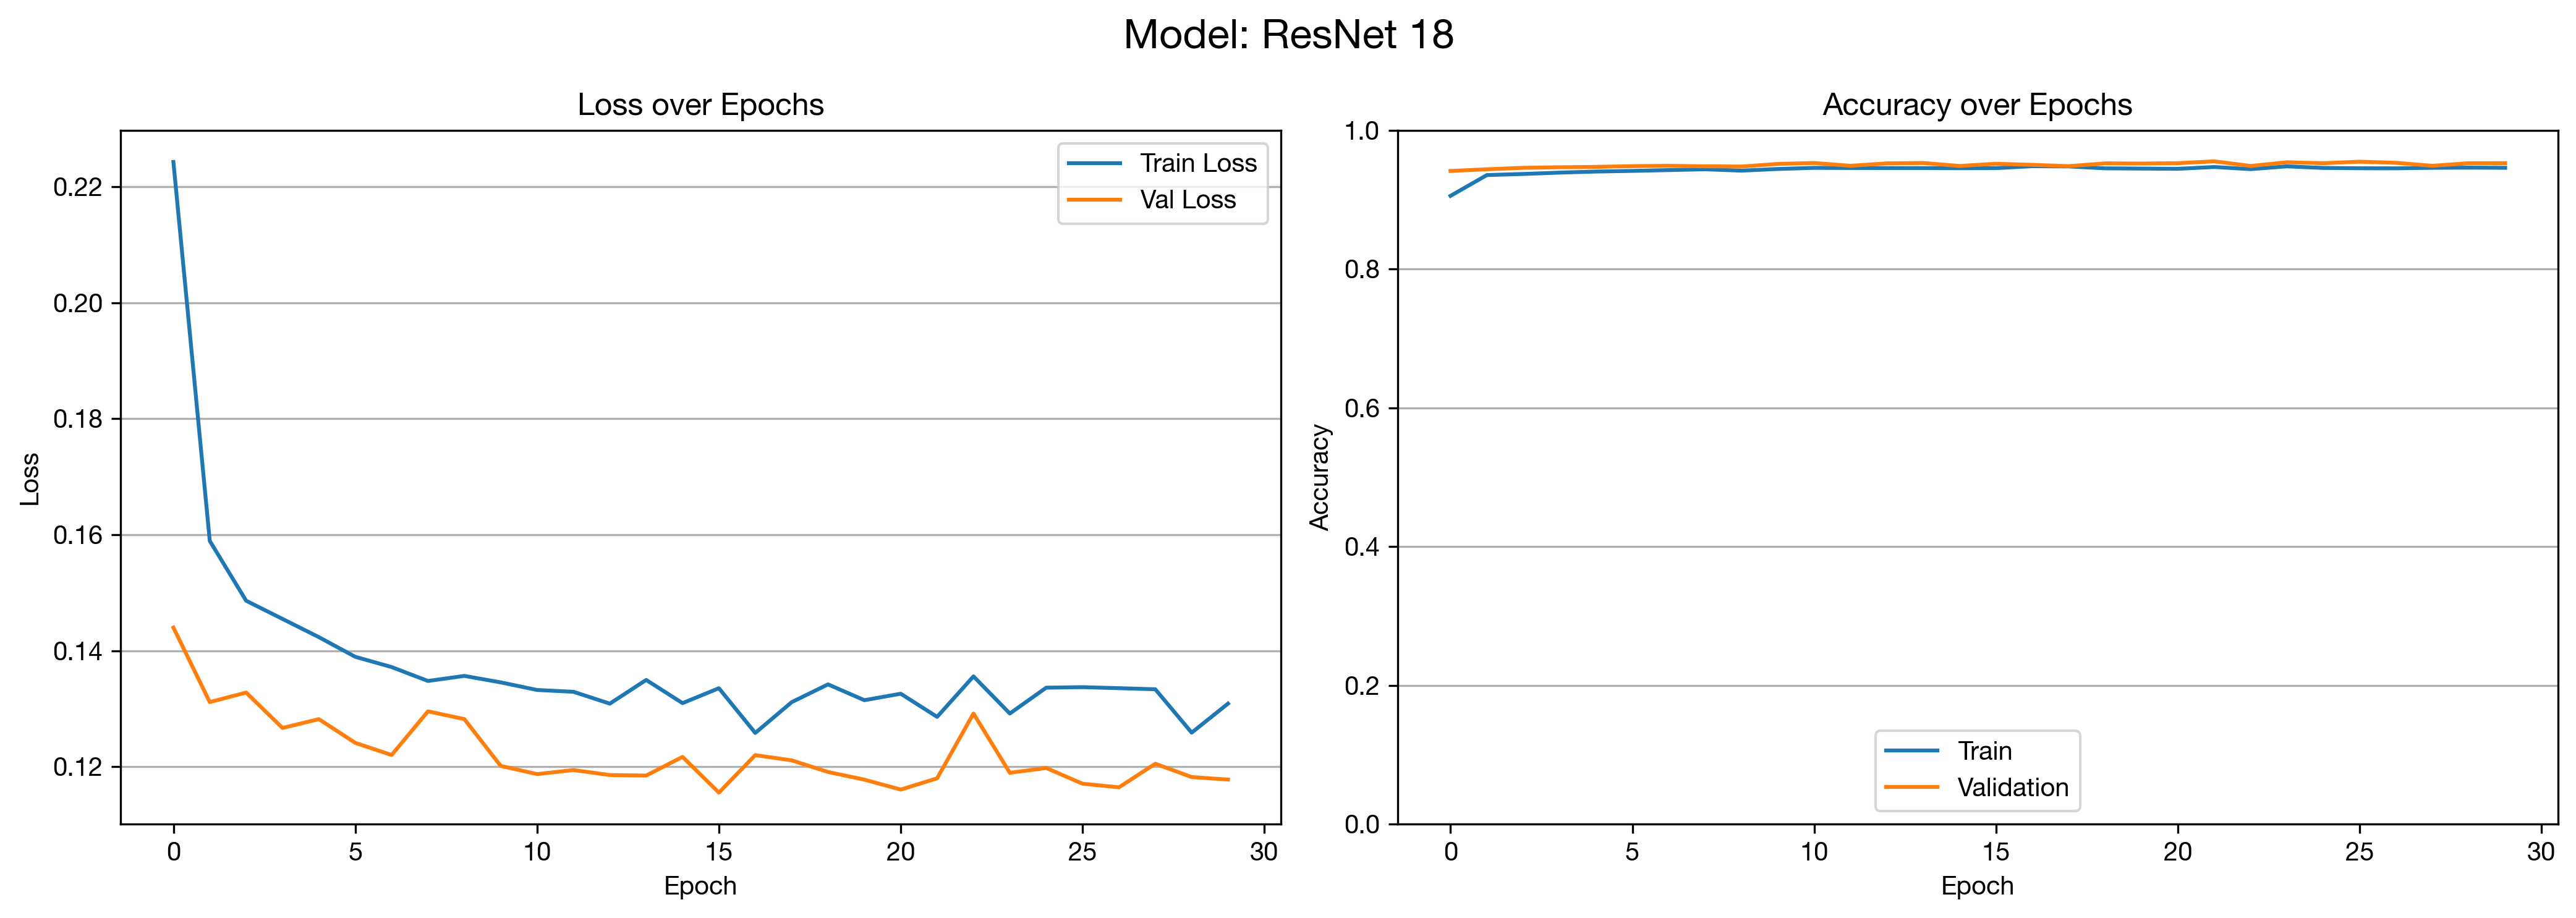

In [ ]:
plot_epochs_graphs(
    resnet_reports, title="Model: ResNet 18", filename="resnet_epochs.png"
)

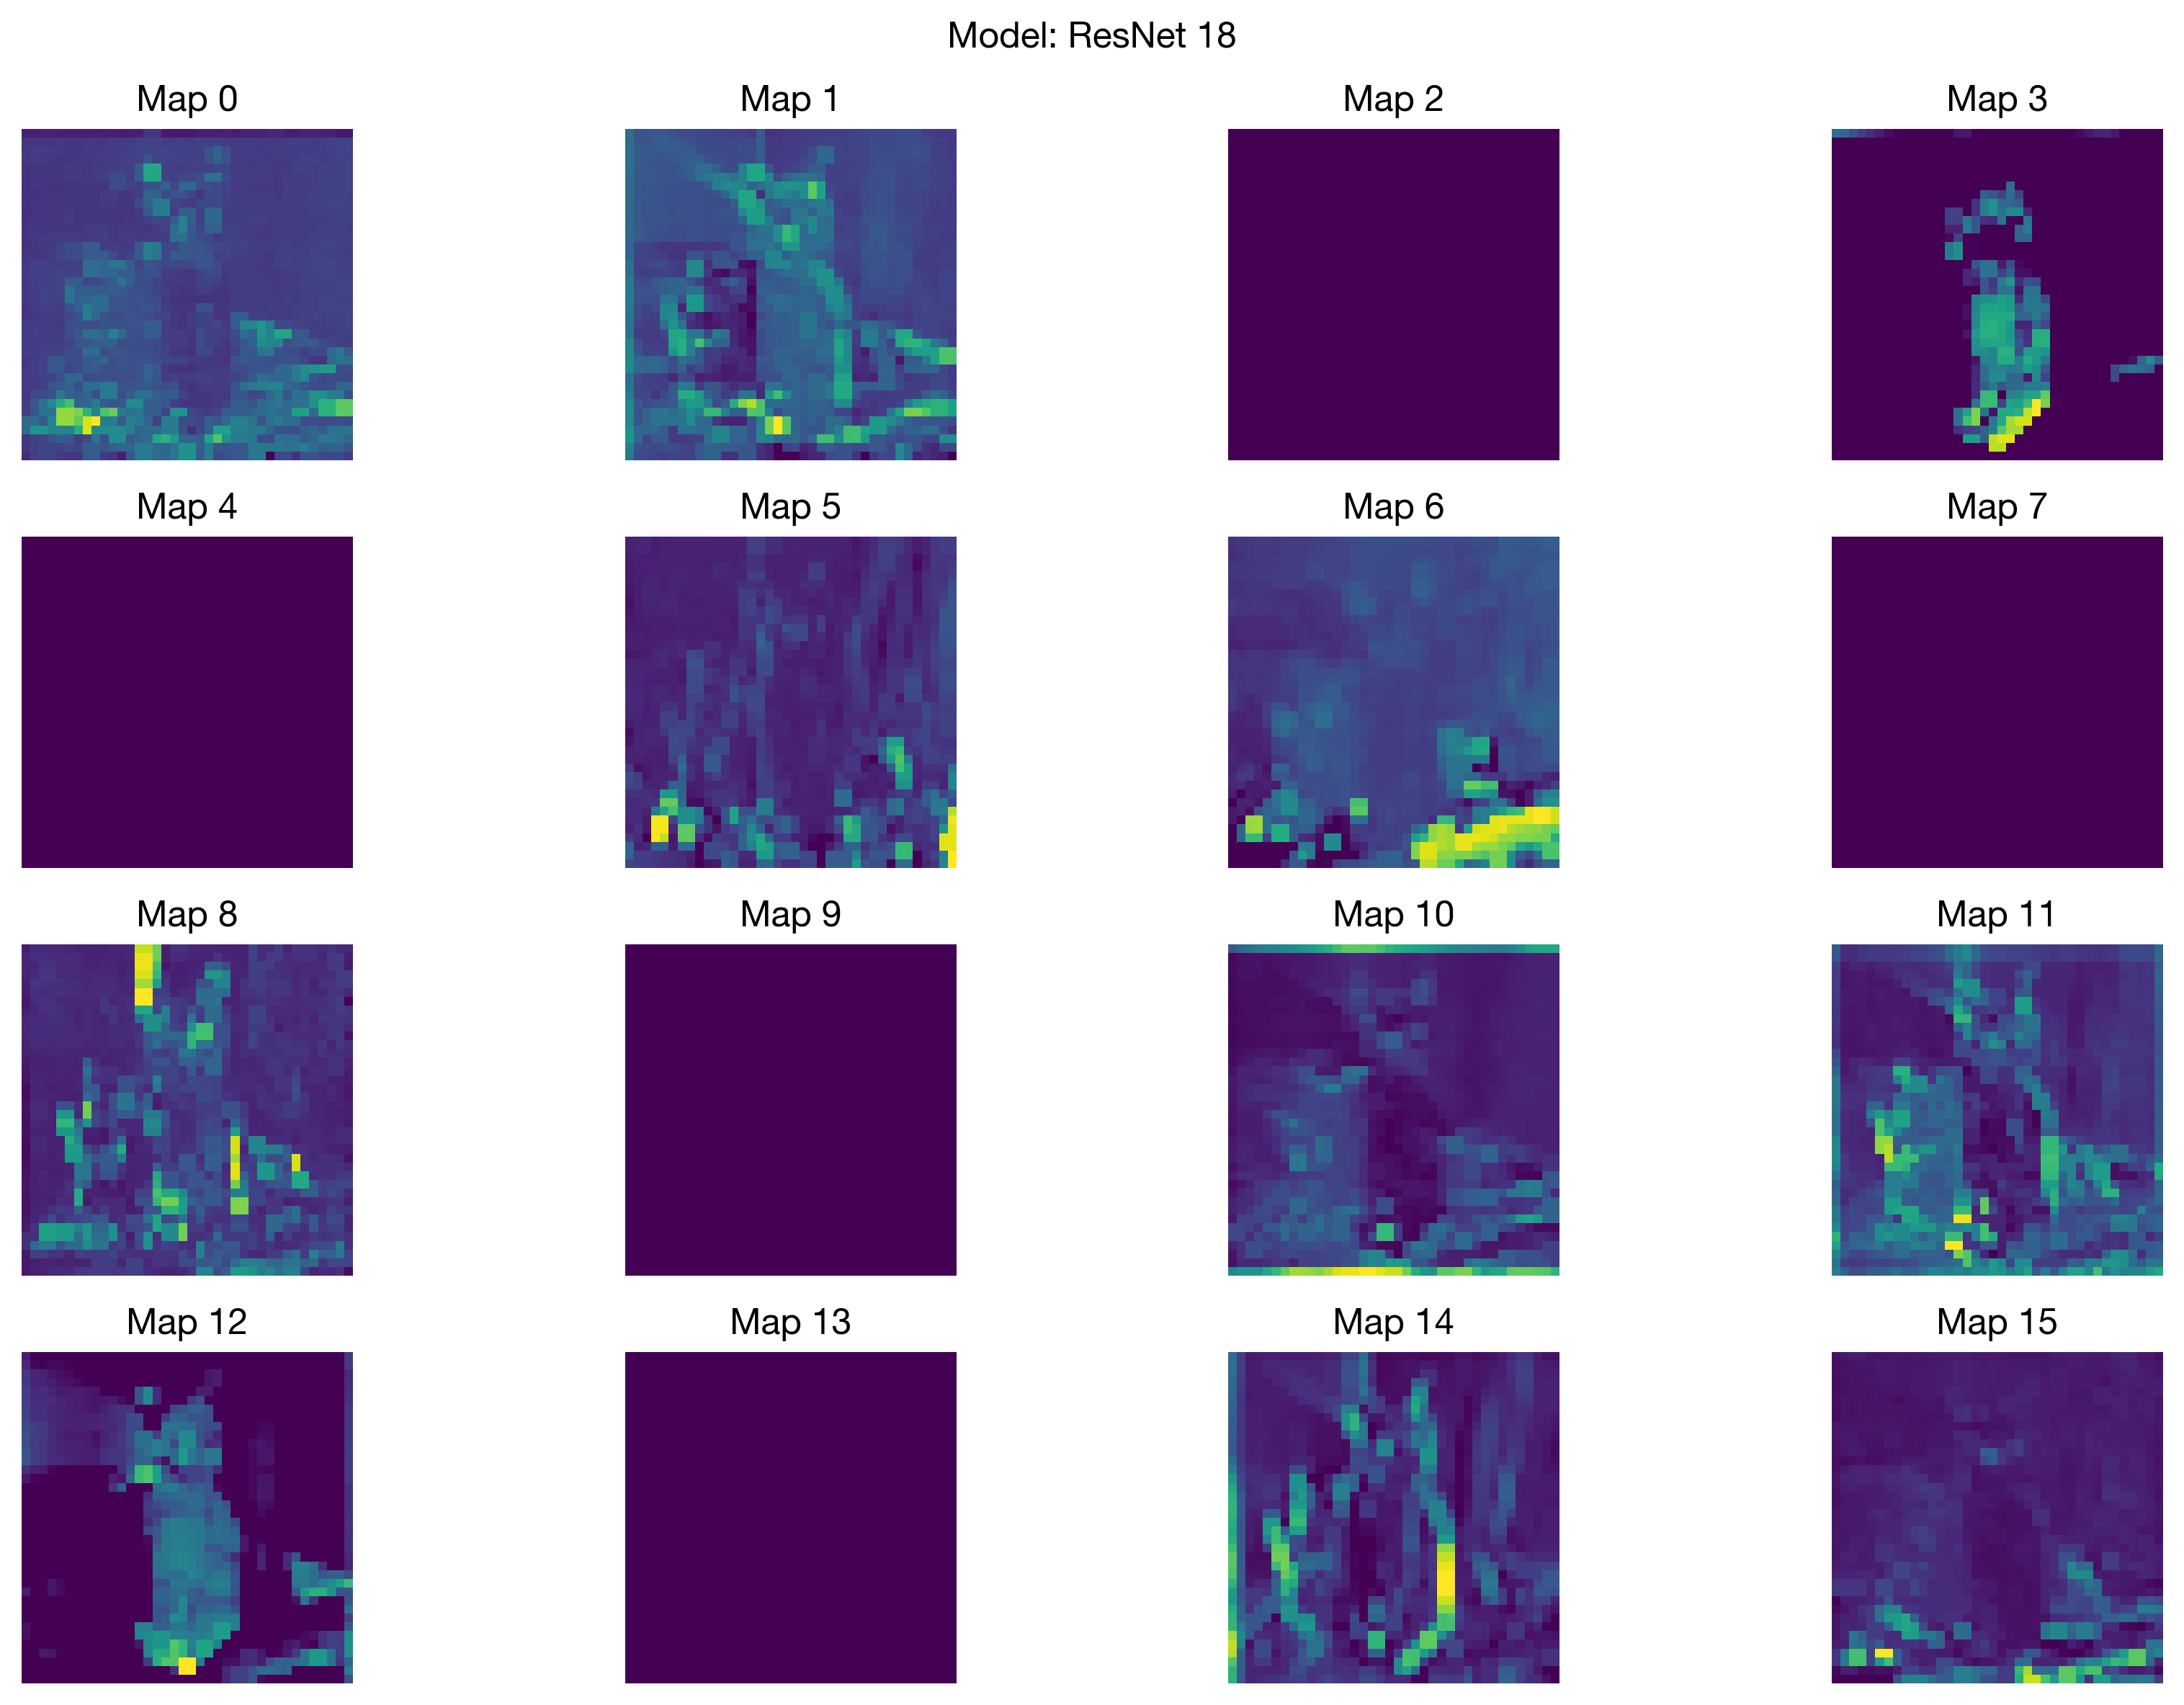

In [ ]:
resnet.eval()
sample_image, _ = next(iter(test_loader))

image_tensor = sample_image[0].unsqueeze(0).to(next(model.parameters()).device)

with torch.no_grad():
    # Forward through initial ResNet layers
    x = model.conv1(image_tensor)  # (B, 64, H, W)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)  # usually downsampled here

feature_maps = x.squeeze(0).cpu()
num_maps = feature_maps.shape[0]

# Plot the first 16 feature maps
plt.figure(figsize=(12, 8))
for i in range(min(16, num_maps)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.axis("off")
    plt.title(f"Map {i}")
plt.suptitle("Model: ResNet 18")

save_path = os.path.join(GRAPHS_PATH, "fm_resnet.png")
plt.savefig(save_path, dpi=300)
plt.tight_layout()

plt.show()

In [97]:
all_preds, all_probs, all_labels = get_model_outputs(model, test_loader, device)

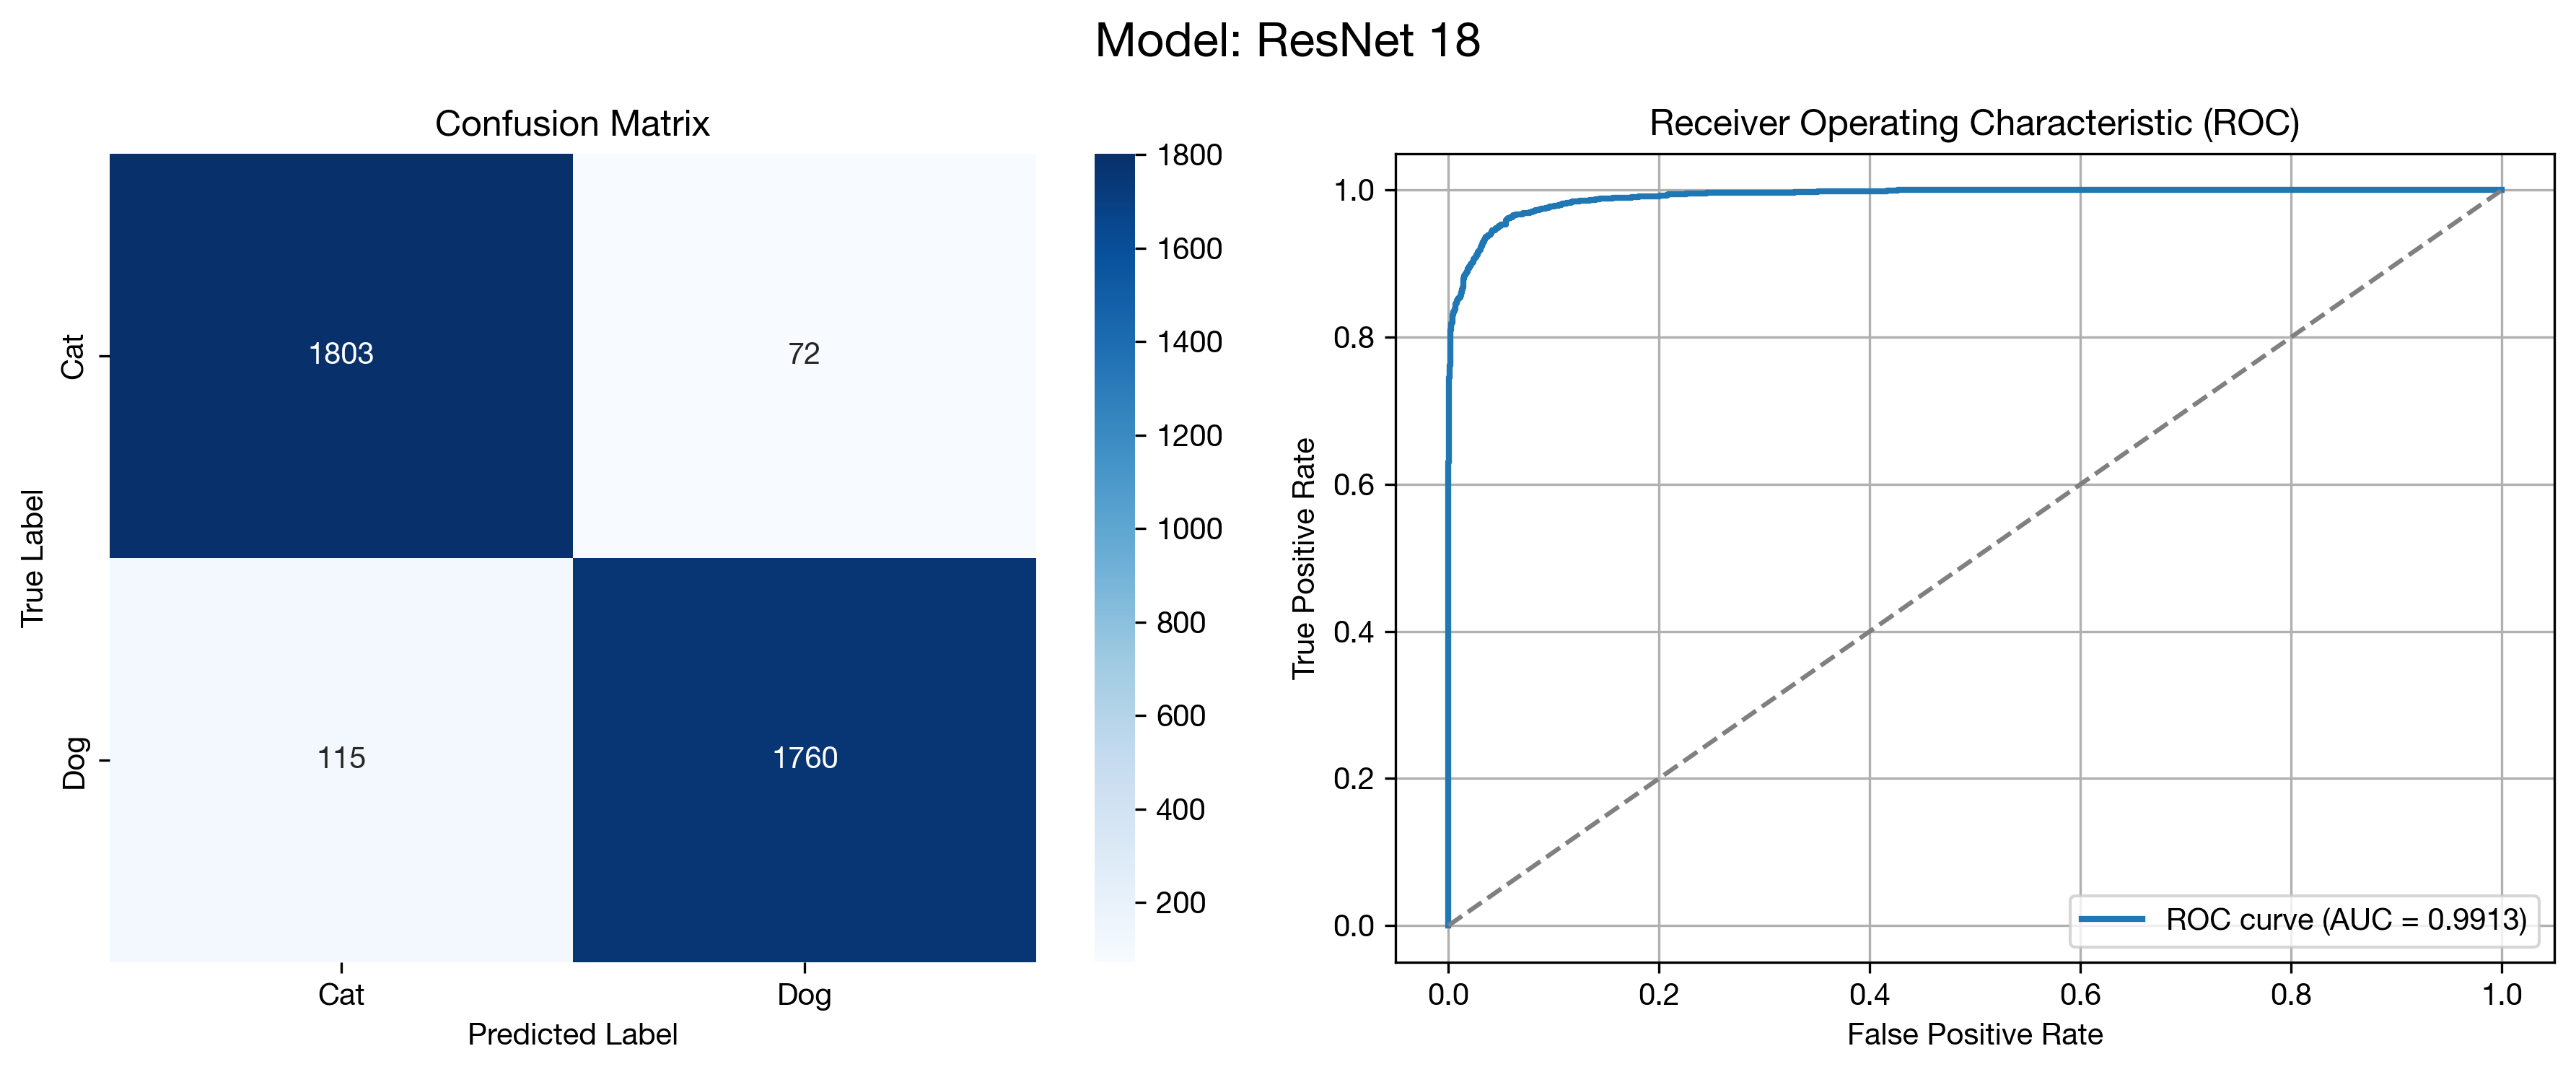

In [ ]:
plot_cm_roc(
    all_labels,
    all_preds,
    all_probs,
    title="Model: ResNet 18",
    filename="metrics_resnet.png",
)

In [ ]:
save_classification_report(all_labels, all_preds, filename="classreport_resnet.png")